In [85]:
import pandas as pd

cityD_df_not_traget = pd.read_csv('HuMob_Data/cityC_challengedata_not_target.csv')
cityD_df_not_traget

,uid,d,t,x,y
0,0,5,15,28,157
1,0,5,16,28,158
2,0,5,17,28,157
3,0,5,18,29,158
4,0,5,19,27,157
...,...,...,...,...,...
16117424,16999,74,25,27,153
16117425,16999,74,34,27,153
16117426,16999,74,36,26,153
16117427,16999,74,43,25,162


In [2]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from transformers.trainer_utils import set_seed
import torch

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]

        if len(generated_rows)>0:
#             print(f"uid: {uid}")
            model_x, model_y = model_xy(uid, data, col_list, model_name)

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

2024-09-08 08:15:51.198499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 08:15:51.272128: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 08:15:51.289274: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 08:15:51.782154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

reading learning function...
reading predicting function...


In [6]:
import pandas as pd

cityD_df_not_traget = pd.read_csv('HuMob_Data/cityB_challengedata_not_target.csv')

# d < 45 のデータがあり、かつ 45 <= d < 60 のデータがない uid を探す
condition1_uids = cityD_df_not_traget.groupby('uid').filter(
    lambda x: (x['d'] < 45).any() and not ((x['d'] >= 45) & (x['d'] < 60)).any()
)['uid'].unique()

print("d < 45 のデータはあるが、d が 45 から 60 のデータがない uid:", condition1_uids)

# d >= 45 のデータしかない uid を探す
condition2_uids = cityD_df_not_traget.groupby('uid').filter(
    lambda x: (x['d'] >= 45).all()
)['uid'].unique()

print("d >= 45 のデータしか, condition2_uids)

d < 45 のデータはあるが、d が 45 から 60 のデータがない uid: [   66  2642  4214  4249  6310  8502  9421  9951 10022 11557 11652 11854
 12137 13009 15158 16598 17781 18832 19089]
d >= 45 のデータしかない uid: [   62   971  1274  2741  4823  8018  9644 10133 10577 12313 12634 13420
 18953]


In [86]:
cityD_df_not_traget = pd.read_csv('HuMob_Data/cityC_challengedata_not_target.csv')

# ユニークなuidを取得
cityD_unique_uids = cityD_df_not_traget['uid'].unique()

# ランダムに300人分のuidを抽出
cityD_df_not_traget_uids = np.random.choice(cityD_unique_uids, size=500, replace=False)

# 抽出したuidに対応するデータを取得
sampled_cityD_df_not_traget = cityD_df_not_traget[cityD_df_not_traget['uid'].isin(cityD_df_not_traget_uids)]
sampled_cityD_df_not_traget = sampled_cityD_df_not_traget.sort_values(by=['uid', 'd', 't'])

# dが60から74のとき、x列とy列を999に置き換える
sampled_reference_cityD_df_not_traget = sampled_cityD_df_not_traget.copy()
sampled_cityD_df_not_traget.loc[sampled_cityD_df_not_traget['d'].between(60, 74), ['x', 'y']] = 999

sampled_cityD_df_not_traget.to_csv('HuMob_Data/cityC_challengedata_not_target_500.csv', index=False)
sampled_reference_cityD_df_not_traget.to_csv('HuMob_Data/cityC_challengedata_not_target_reference_500.csv', index=False)

# 0日目の曜日分析

In [39]:
import time
from datetime import datetime, timedelta
import jpholiday
import warnings

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)
set_random_seed(42)

def evaluation_test(data, reference_data):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    # for uid in uids:
    #     generated = []
    #     reference = []
    #     # print(f"uid: {uid}")

    #     # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
    #     mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
    #     generated_rows = data[mask]

    # 平均値の計算
    mean_values = data[(data['x'] != 999) & (data['y'] != 999)].groupby(['uid', 'weekday_flag']).agg({'x': 'mean', 'y': 'mean'})
    
    # 各uid, day_of_weekごとの平均値を999の部分に適用
    def replace_with_mean(row, col):
        key = (row['uid'], row['weekday_flag'])
        if row[col] == 999:
            # 存在しないキーへのアクセスを防ぐ
            if key in mean_values.index:
                return mean_values.at[key, col]
            else:
                return 999  # もしくはNaNなど適切なデフォルト値
        else:
            return row[col]
    
    generated_rows = data[(data['x'] == 999) | (data['y'] == 999)].copy()
    generated_rows['x'] = generated_rows.apply(replace_with_mean, col='x', axis=1)
    generated_rows['y'] = generated_rows.apply(replace_with_mean, col='y', axis=1)

    reference_data = reference_data[reference_data['d'] >= 60]

    display(generated_rows.head(3))

    for uid in uids:
        if len(generated_rows) > 0:
                
            generated_uid = generated_rows[generated_rows['uid']==uid]
            reference_uid = reference_data[reference_data['uid']==uid]

            # (d, t, x, y)のタプルのリストを作成
            generated = [tuple(row) for row in generated_uid[['d', 't', 'x', 'y']].to_numpy()]
            reference = [tuple(row) for row in reference_uid[[ 'd', 't', 'x', 'y']].to_numpy()]
            
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)


def featurecreation_test(data, day_of_week_mapping):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # d % 7 の値を文字列に変換
    data['day_of_week'] = data['d'] % 7
    data['day_of_week'] = data['day_of_week'].map(day_of_week_mapping)
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data.loc[data['day_of_week'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    # dummies = pd.get_dummies(data['day_of_week']).astype(int)
    # data = pd.concat([data, dummies], axis=1)
    # data = data.drop(columns=['day_of_week'])

    print('complete create feature...')

    display(data.head(2))
    
    return data

base_day_of_week = [
    {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'},
    {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'},
    {0: 'Tue', 1: 'Wed', 2: 'Thu', 3: 'Fri', 4: 'Sat', 5: 'Sun', 6: 'Mon'},
    {0: 'Wed', 1: 'Thu', 2: 'Fri', 3: 'Sat', 4: 'Sun', 5: 'Mon', 6: 'Tue'},
    {0: 'Thu', 1: 'Fri', 2: 'Sat', 3: 'Sun', 4: 'Mon', 5: 'Tue', 6: 'Wed'},
    {0: 'Fri', 1: 'Sat', 2: 'Sun', 3: 'Mon', 4: 'Tue', 5: 'Wed', 6: 'Thu'},
    {0: 'Sat', 1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri'},
]

for day_of_week_mapping in base_day_of_week:
    set_random_seed(42)
    print(day_of_week_mapping)
    
    df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
    df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

    display(df_cityD_target.head(2))
    
    # 特徴量エンジニアリング
    df_cityD_target = featurecreation_test(df_cityD_target, day_of_week_mapping)
    df_cityD_reference = featurecreation_test(df_cityD_reference, day_of_week_mapping)
    
    start = time.perf_counter()
    
    basic_col = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM
    evaluation_test(df_cityD_target, df_cityD_reference)
    
    end = time.perf_counter()
    print('{:.2f}分'.format((end-start)/60))

{0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}


,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Sun,0
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Sun,0


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Sun,0
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Sun,0


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
1394,0,60,12,131.868246,100.451185,-0.433884,-0.900969,1.000000,6.123234e-17,Thu,1
1395,0,60,13,131.868246,100.451185,-0.433884,-0.900969,0.991445,-1.305262e-01,Thu,1
1396,0,60,14,131.868246,100.451185,-0.433884,-0.900969,0.965926,-2.588190e-01,Thu,1


Average geobleu: 0.059153967980944196
Standard deviation geobleu: 0.10404088976356059
Average dtw: 63.786545134117844
Standard deviation dtw: 58.66018849831412
1.38分
{0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}


,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Mon,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Mon,1


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Mon,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Mon,1


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
1394,0,60,12,132.075117,101.401878,-0.433884,-0.900969,1.000000,6.123234e-17,Fri,1
1395,0,60,13,132.075117,101.401878,-0.433884,-0.900969,0.991445,-1.305262e-01,Fri,1
1396,0,60,14,132.075117,101.401878,-0.433884,-0.900969,0.965926,-2.588190e-01,Fri,1


Average geobleu: 0.055543941171715634
Standard deviation geobleu: 0.10130143934728243
Average dtw: 64.94406369563166
Standard deviation dtw: 60.6517511129519
1.39分
{0: 'Tue', 1: 'Wed', 2: 'Thu', 3: 'Fri', 4: 'Sat', 5: 'Sun', 6: 'Mon'}


,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Tue,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Tue,1


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Tue,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Tue,1


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
1394,0,60,12,131.553846,98.202564,-0.433884,-0.900969,1.000000,6.123234e-17,Sat,0
1395,0,60,13,131.553846,98.202564,-0.433884,-0.900969,0.991445,-1.305262e-01,Sat,0
1396,0,60,14,131.553846,98.202564,-0.433884,-0.900969,0.965926,-2.588190e-01,Sat,0


Average geobleu: 0.05688888260929038
Standard deviation geobleu: 0.10150826966393069
Average dtw: 64.92972167833247
Standard deviation dtw: 61.615904320814415
1.40分
{0: 'Wed', 1: 'Thu', 2: 'Fri', 3: 'Sat', 4: 'Sun', 5: 'Mon', 6: 'Tue'}


,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Wed,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Wed,1


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Wed,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Wed,1


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
1394,0,60,12,131.029197,98.781022,-0.433884,-0.900969,1.000000,6.123234e-17,Sun,0
1395,0,60,13,131.029197,98.781022,-0.433884,-0.900969,0.991445,-1.305262e-01,Sun,0
1396,0,60,14,131.029197,98.781022,-0.433884,-0.900969,0.965926,-2.588190e-01,Sun,0


Average geobleu: 0.05570779878154793
Standard deviation geobleu: 0.10070807960047705
Average dtw: 66.69065616053179
Standard deviation dtw: 73.33292143125017
1.41分
{0: 'Thu', 1: 'Fri', 2: 'Sat', 3: 'Sun', 4: 'Mon', 5: 'Tue', 6: 'Wed'}


,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Thu,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Thu,1


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Thu,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Thu,1


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
1394,0,60,12,129.849539,104.85261,-0.433884,-0.900969,1.000000,6.123234e-17,Mon,1
1395,0,60,13,129.849539,104.85261,-0.433884,-0.900969,0.991445,-1.305262e-01,Mon,1
1396,0,60,14,129.849539,104.85261,-0.433884,-0.900969,0.965926,-2.588190e-01,Mon,1


Average geobleu: 0.055734095240729656
Standard deviation geobleu: 0.09901691550813471
Average dtw: 64.6894757877252
Standard deviation dtw: 60.73828109111657
1.41分
{0: 'Fri', 1: 'Sat', 2: 'Sun', 3: 'Mon', 4: 'Tue', 5: 'Wed', 6: 'Thu'}


,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Fri,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Fri,1


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Fri,1
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Fri,1


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
1394,0,60,12,129.008457,105.365751,-0.433884,-0.900969,1.000000,6.123234e-17,Tue,1
1395,0,60,13,129.008457,105.365751,-0.433884,-0.900969,0.991445,-1.305262e-01,Tue,1
1396,0,60,14,129.008457,105.365751,-0.433884,-0.900969,0.965926,-2.588190e-01,Tue,1


Average geobleu: 0.05580243352590247
Standard deviation geobleu: 0.10044805131216998
Average dtw: 64.74666583058412
Standard deviation dtw: 60.70633517926216
1.41分
{0: 'Sat', 1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri'}


,uid,d,t,x,y
0,0,0,13,133,103
1,0,0,14,143,98


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Sat,0
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Sat,0


start create feature...
complete create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
0,0,0,13,133,103,0.0,1.0,0.991445,-0.130526,Sat,0
1,0,0,14,143,98,0.0,1.0,0.965926,-0.258819,Sat,0


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,day_of_week,weekday_flag
1394,0,60,12,129.467021,103.445745,-0.433884,-0.900969,1.000000,6.123234e-17,Wed,1
1395,0,60,13,129.467021,103.445745,-0.433884,-0.900969,0.991445,-1.305262e-01,Wed,1
1396,0,60,14,129.467021,103.445745,-0.433884,-0.900969,0.965926,-2.588190e-01,Wed,1


Average geobleu: 0.05658291466399814
Standard deviation geobleu: 0.10096324440106404
Average dtw: 65.28836123054616
Standard deviation dtw: 61.823610182182236
1.41分


# 分類 ±1 or 0 をしたときの精度比較

In [222]:
import time
from datetime import datetime, timedelta
import jpholiday
import warnings
import pandas as pd
import numpy as np

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    return data

np.random.seed(42)

# 999でない値にランダムに+1, -1, 0を加える関数
def random_adjust(value):
    if value != 999:
        return value + np.random.choice([0, -1, 1], p=[0.95, 0.025, 0.025])  # 90%の確率で0、5%の確率で-1または+1
    return value


# x列とy列に対するランダム調整を行う関数
def random_adjust_v2(x_value, y_value):
    if x_value != 999 or y_value != 999:
        # 80%の確率でxとyを別々に±1を行う
        if np.random.rand() < 0.8:
            x_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if x_value != 999 else 0
            y_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if y_value != 999 else 0
        else:
            # 20%の確率でxとyに同じ±1を行う
            adjustment = np.random.choice([0, -1, 1], p=[0.9, 0.05, 0.05])
            x_adjust = adjustment if x_value != 999 else 0
            y_adjust = adjustment if y_value != 999 else 0
        return x_value + x_adjust, y_value + y_adjust
    return x_value, y_value
    
# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

# IDごとに最頻値を計算
# modes = df_cityD_target.groupby('uid').apply(lambda group: pd.Series({
#     'x_mode': group['x'].mode()[0],
#     'y_mode': group['y'].mode()[0],
#     'xy_mode': group.groupby(['x', 'y']).size().idxmax()
# }))

# 滞在時間の計算
df_cityD_target['stay_time'] = (df_cityD_target['d'].diff() * 48 + df_cityD_target['t'].diff()).fillna(0)

# xとyの組み合わせごとに滞在時間の平均を計算
mean_stay_times = df_cityD_target.groupby(['x', 'y'])['stay_time'].mean().reset_index()

# 滞在時間の平均が長い順にソート
mean_stay_times = mean_stay_times.sort_values(by='stay_time', ascending=False)

# 平均滞在時間が最も長いxとyの組み合わせと次に長い組み合わせを取得
top_combinations = mean_stay_times.iloc[:2][['x', 'y']].values

# x列とy列に対するランダム調整を行う関数
def random_adjust_v3(row, modes):
    x_value = row['x']
    y_value = row['y']
    ID = row['uid']
    
    # x_mode = modes.loc[ID, 'x_mode']
    # y_mode = modes.loc[ID, 'y_mode']
    xy_mode = modes.loc[ID, 'xy_mode']
    
    # if x_value == x_mode or y_value == y_mode or (x_value, y_value) == xy_mode:
    if (x_value, y_value) == xy_mode:
        return x_value, y_value  # 最頻値に対しては調整を加えない
    
    if x_value != 999 or y_value != 999:
        # 80%の確率でxとyを別々に±1を行う
        if np.random.rand() < 0.8:
            x_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if x_value != 999 else 0
            y_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if y_value != 999 else 0
        else:
            # 20%の確率でxとyに同じ±1を行う
            adjustment = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2])
            x_adjust = adjustment if x_value != 999 else 0
            y_adjust = adjustment if y_value != 999 else 0
        return x_value + x_adjust, y_value + y_adjust
    
    return x_value, y_value

def random_adjust_v4(row, top_combinations):
    
    x_value = row['x']
    y_value = row['y']
    current_combination = (x_value, y_value)
    
    # 平均滞在時間が最も長い2つの組み合わせに対しては調整を加えない
    if any(np.array_equal(current_combination, comb) for comb in top_combinations):
        return x_value, y_value
    
    if x_value != 999 or y_value != 999:
        # 80%の確率でxとyを別々に±1を行う
        if np.random.rand() < 0.8:
            x_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if x_value != 999 else 0
            y_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if y_value != 999 else 0
            x_adjust = np.where(x_adjust < 1, 1, np.where(x_adjust > 200, 200, x_adjust.round().astype(int)))
            y_adjust = np.where(y_adjust < 1, 1, np.where(y_adjust > 200, 200, y_adjust.round().astype(int)))
        else:
            # 20%の確率でxとyに同じ±1を行う
            adjustment = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2])
            x_adjust = adjustment if x_value != 999 else 0
            y_adjust = adjustment if y_value != 999 else 0
            x_adjust = np.where(x_adjust < 1, 1, np.where(x_adjust > 200, 200, x_adjust.round().astype(int)))
            y_adjust = np.where(y_adjust < 1, 1, np.where(y_adjust > 200, 200, y_adjust.round().astype(int)))
        return x_value + x_adjust, y_value + y_adjust
    
    return x_value, y_value
    
# df_cityD_target['x'] = df_cityD_target['x'].apply(random_adjust)
# df_cityD_target['y'] = df_cityD_target['y'].apply(random_adjust)

df_cityD_target['x'], df_cityD_target['y'] = zip(*df_cityD_target.apply(lambda row: random_adjust_v2(row['x'], row['y']), axis=1))
# df_cityD_target[['x', 'y']] = df_cityD_target.apply(lambda row: pd.Series(random_adjust_v4(row, modes)), axis=1)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos']
model_name = 'SVR' # SVR, RandomForest, LinearRegression, LGBM
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
start create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535


In [17]:
start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos']
model_name = 'RandomForest' # SVR, RandomForest, LinearRegression, LGBM
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535
uid: 543
uid: 544
uid: 554
uid: 555
uid: 557
uid

# データ取得日分析

In [16]:

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)
    dummies = pd.get_dummies(data['dow'])
    data = pd.concat([data, dummies], axis=1)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 活動時間追加
    data['activetime'] = data['t'].apply(lambda x: 'act' if (18 <= x <= 22) or (33 <= x <= 37) else ('high_act' if (23 <= x <= 32) else ('rest' if (13 <= x <= 17) or (38 <= x <= 43) else ('deep_rest' if (0 <= x <= 12) or (44 <= x <= 48) else np.nan))))
    dummies_1 = pd.get_dummies(data['activetime'])
    dummies_1 = dummies_1.astype(int)
    data = pd.concat([data, dummies_1], axis=1)

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    # グループ化してサイズ（データポイント数）を計算
    # grouped = data.groupby(['uid', 't', 'dow']).size().reset_index(name='count')
    
    # # 各 uid と t の組み合わせに対して中央値を計算
    # grouped['median_count'] = grouped.groupby(['uid', 't', 'dow'])['count'].transform('median')
    
    # # 基のデータフレームに median_count をマージ
    # data = data.merge(grouped[['uid', 't', 'dow', 'median_count']], on=['uid', 't', 'dow'], how='left')

    print('complete create feature...')

    # display(data)
    
    return data

# 0日目が日曜で37日目が火曜祝日？
# 2020年2月11日 or 2020年11月3日 or 2019年10月22日 or 2023年3月21日を基準日として設定
base_dates = [
    datetime(2019, 1, 1),
    # datetime(2019, 10, 22),
    datetime(2020, 2, 11),
    # datetime(2020, 11, 3),
    datetime(2021, 2, 23),
    # datetime(2021, 11, 23),
    # datetime(2023, 3, 21),
]

# base_date = datetime(2020, 11, 3)
for base_date in base_dates:
    set_random_seed(42)
    print(base_date)
    
    df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
    df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')
    
    # d列を日にちに変換して新しい列を作成
    df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
    df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))
    
    # 特徴量エンジニアリング
    df_cityD_target = featurecreation(df_cityD_target)
    df_cityD_reference = featurecreation(df_cityD_reference)
    
    start = time.perf_counter()
    
    # basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'holiday_flag', 'weekday_flag', 'weekend_flag']
    basic_col = ['holiday_flag', 'weekday_flag', 'weekend_flag']
    model_name = 'RandomForest' # SVR, RandomForestRegressor, LinearRegression, LGBM
    evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

    # basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'holiday_flag', 'weekday_flag', 'weekend_flag']
    # evaluation(sampled_cityD_df_not_traget, sampled_reference_cityD_df_not_traget, basic_col, model_name)
    
    end = time.perf_counter()
    print('{:.2f}分'.format((end-start)/60))

2019-01-01 00:00:00
start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 49

# 特徴量作成

In [3]:
from datetime import datetime, timedelta
import jpholiday
import time
from scipy.stats import gaussian_kde
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation_v1(data):
    '''
    dが60以上の場合でも問題なくそのまま付与できる変数作成
    '''

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)
    # dummies = pd.get_dummies(data['dow'])
    # data = pd.concat([data, dummies], axis=1)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 活動時間追加
    # data['activetime'] = data['t'].apply(lambda x: 'act' if (18 <= x <= 22) or (33 <= x <= 37) else ('high_act' if (23 <= x <= 32) else ('rest' if (13 <= x <= 17) or (38 <= x <= 43) else ('deep_rest' if (0 <= x <= 12) or (44 <= x <= 48) else np.nan))))
    # dummies_1 = pd.get_dummies(data['activetime'])
    # dummies_1 = dummies_1.astype(int)
    # data = pd.concat([data, dummies_1], axis=1)

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    # uid ごとに t の観測回数をカウントして元のデータフレームに結合
    t_observation_count = data.groupby(['uid', 't']).size().reset_index(name='t_observation_count')
    
    # MinMaxScaler を使用して、観測回数を 0-1 の範囲に正規化
    # scaler = MinMaxScaler()
    # t_observation_count['t_observation_scaled'] = t_observation_count.groupby('uid')['t_observation_count'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)))
    
    # 元のデータフレームに観測回数と正規化された値を結合
    data = pd.merge(data, t_observation_count, on=['uid', 't'], how='left')

    # uid ごとに昼行性/夜行性の判定
    # time_point が 1 の場合 (昼行性) に t_observation_count が多ければ 1, 少なければ 0
    data['diurnal'] = data.groupby('uid')['t_observation_count'].transform(lambda x: 1 if x[data['time_point'] == 1].sum() > x[data['time_point'] == 0].sum() else 0)
    
    # time_point が 0 の場合 (夜行性) に t_observation_count が多ければ 1, 少なければ 0
    data['nocturnal'] = data.groupby('uid')['t_observation_count'].transform(lambda x: 1 if x[data['time_point'] == 0].sum() > x[data['time_point'] == 1].sum() else 0)
    
    # 月の日数を取得するための関数 (その月の最終日)
    data['days_in_month'] = data['date'].dt.daysinmonth
    
    # 月の進行度を計算 (その月の日 / 月の日数)
    data['month_progress'] = data['date'].dt.day / data['days_in_month']

    # 時間帯ごとの観測回数を計算
    data['time_bin'] = pd.cut(data['t'], bins=[0, 12, 24, 36, 48], labels=['0-6', '6-12', '12-18', '18-24'], right=False)
    time_bin_counts = data.groupby(['uid', 'time_bin']).size().unstack(fill_value=0)
    time_bin_counts = time_bin_counts.stack().reset_index(name='time_bin_count')
    
    # 元のデータフレームに結合
    data = pd.merge(data, time_bin_counts, on=['uid', 'time_bin'], how='left')
    
    # # 観測時間のカーネル密度推定（KDE）を計算
    # def calculate_kde(uid_group):
    #     kde = gaussian_kde(uid_group['t'])  # KDEを計算
    #     return kde.evaluate(uid_group['t'])  # 観測された時間の密度を返す
    
    # data['kde_density'] = data.groupby('uid', group_keys=False).apply(calculate_kde)

    # uid ごとに d と t の出現回数を計算
    t_counts = data.groupby(['uid', 'd', 't']).size().reset_index(name='t_count')
    
    # uid ごとの日にちにおける t の総数を計算して出現回数で割る
    t_counts['t_total'] = t_counts.groupby(['uid', 'd'])['t_count'].transform('sum')
    t_counts['t_ratio'] = t_counts['t_count'] / t_counts['t_total']
    
    # 元のデータフレームに結合
    data = pd.merge(data, t_counts[['uid', 'd', 't', 't_ratio']], on=['uid', 'd', 't'], how='left')

    # time_bin を数値に変換
    # 0-6 => 0, 6-12 => 1, 12-18 => 2, 18-24 => 3 に変換する
    time_bin_mapping = {'0-6': 0, '6-12': 1, '12-18': 2, '18-24': 3}
    data['time_bin_numeric'] = data['time_bin'].map(time_bin_mapping).astype(int)
    
    # time_bin の数値を sin と cos に変換
    # 時間帯は4つの周期なので、2 * pi / 4 で周期を調整する
    data['time_bin_sin'] = np.sin(2 * np.pi * data['time_bin_numeric'] / 4)
    data['time_bin_cos'] = np.cos(2 * np.pi * data['time_bin_numeric'] / 4)

    print('complete create feature...')
    
    return data

def featurecreation_v2(data):
    '''
    dが60以上の場合だとそのまま付与できない変数作成
    '''
    print('start create feature...')

    filtered_df = data[data['d'] < 60]

    # 過去のx, y座標の変化量（移動距離）
    filtered_df['x_diff'] = filtered_df.groupby('uid')['x'].diff()
    filtered_df['y_diff'] = filtered_df.groupby('uid')['y'].diff()
    filtered_df['time'] = filtered_df['d']*48 + filtered_df['t']
    filtered_df['t_diff'] = filtered_df.groupby('uid')['time'].diff()
    filtered_df = filtered_df.dropna()
    filtered_df['movement_distance'] = np.sqrt(filtered_df['x_diff']**2 + filtered_df['y_diff']**2)
    filtered_df['movement_speed'] = (np.sqrt(filtered_df['x_diff']**2 + filtered_df['y_diff']**2))/filtered_df['t_diff']
    
    grouped = filtered_df.groupby(['uid', 't_diff']).agg(
        movement_distance_min=('movement_distance', 'min'),
        movement_distance_max=('movement_distance', 'max'),
        movement_distance_mean=('movement_distance', 'mean'),
    
        movement_speed_min=('movement_speed', 'min'),
        movement_speed_max=('movement_speed', 'max'),
        movement_speed_mean=('movement_speed', 'mean'),
    ).reset_index()

    data['time'] = data['d']*48 + data['t']
    data['t_diff'] = data.groupby('uid')['time'].diff()
    # 元のデータフレームに d に関係なく結合
    data = pd.merge(data, grouped, on=['uid', 't_diff'], how='left')

    time_diff_stats = data.groupby('uid')['t_diff'].agg(['mean', 'std', 'min', 'max']).reset_index()
    data = pd.merge(data, time_diff_stats, on='uid', how='left', suffixes=('', '_time_diff_stats'))

    data = data.dropna()

    print('complete create feature...')

    # display(data)
    
    return data


df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

# d列を日にちに変換して新しい列を作成
df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

# 特徴量エンジニアリング
df_cityD_target = featurecreation_v1(df_cityD_target)
df_cityD_target = featurecreation_v2(df_cityD_target)
# df_cityD_reference = featurecreation(df_cityD_reference)

print(df_cityD_target.columns)
df_cityD_target.head()

start create feature...


/tmp/ipykernel_5796/1706757595.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_bin_counts = data.groupby(['uid', 'time_bin']).size().unstack(fill_value=0)


complete create feature...
start create feature...


/tmp/ipykernel_5796/1706757595.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['x_diff'] = filtered_df.groupby('uid')['x'].diff()
/tmp/ipykernel_5796/1706757595.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['y_diff'] = filtered_df.groupby('uid')['y'].diff()
/tmp/ipykernel_5796/1706757595.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

complete create feature...
Index(['uid', 'd', 't', 'x', 'y', 'date', 'd_sin', 'd_cos', 't_sin', 't_cos',
       'dow', 'time_point', 'weekday_flag', 'weekend_flag', 'holiday_flag',
       't_observation_count', 'diurnal', 'nocturnal', 'days_in_month',
       'month_progress', 'time_bin', 'time_bin_count', 't_ratio',
       'time_bin_numeric', 'time_bin_sin', 'time_bin_cos', 'time', 't_diff',
       'movement_distance_min', 'movement_distance_max',
       'movement_distance_mean', 'movement_speed_min', 'movement_speed_max',
       'movement_speed_mean', 'mean', 'std', 'min', 'max'],
      dtype='object')


,uid,d,t,x,y,date,d_sin,d_cos,t_sin,t_cos,...,movement_distance_min,movement_distance_max,movement_distance_mean,movement_speed_min,movement_speed_max,movement_speed_mean,mean,std,min,max
1,0,0,14,143,98,2020-01-05,0.0,1.0,0.965926,-0.258819,...,0.0,56.568542,10.177822,0.0,56.568542,10.177822,2.012353,4.063521,1.0,78.0
2,0,0,16,162,99,2020-01-05,0.0,1.0,0.866025,-0.500000,...,0.0,22.627417,6.137440,0.0,11.313708,3.068720,2.012353,4.063521,1.0,78.0
3,0,0,17,149,97,2020-01-05,0.0,1.0,0.793353,-0.608761,...,0.0,56.568542,10.177822,0.0,56.568542,10.177822,2.012353,4.063521,1.0,78.0
4,0,0,18,144,98,2020-01-05,0.0,1.0,0.707107,-0.707107,...,0.0,56.568542,10.177822,0.0,56.568542,10.177822,2.012353,4.063521,1.0,78.0
5,0,0,20,160,100,2020-01-05,0.0,1.0,0.500000,-0.866025,...,0.0,22.627417,6.137440,0.0,11.313708,3.068720,2.012353,4.063521,1.0,78.0


In [4]:
start = time.perf_counter()

# basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'holiday_flag', 'weekday_flag', 'weekend_flag', 'time_point']
# basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
# basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point', 't_observation_count', 'diurnal', 'nocturnal',
#             'time_bin_sin', 'time_bin_cos', 'time_bin_count', 't_ratio', 'movement_distance_min', 'movement_distance_max', 'movement_distance_mean', 'movement_speed_min',
#             'movement_speed_max', 'movement_speed_mean', 't_diff', 'mean', 'std', 'min', 'max']
basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point', 't_observation_count', 'diurnal', 'month_progress',
            'time_bin_sin', 'time_bin_cos', 't_ratio', 'movement_distance_min', 'movement_distance_max', 'movement_distance_mean', 'movement_speed_min',
            'movement_speed_max', 'movement_speed_mean', 't_diff', 'mean', 'std', 'min', 'max']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM, TabPFN
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535
uid: 543
uid: 544
uid: 554
uid: 555
uid: 557
uid

# 地点間差分予測タスク

In [13]:
def set_random_seed(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)

def model_xy_v2(uid, data, col_list, model_name):

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    # 差分の最小値を求める
    min_x_diff = data[data['d']<60]['x_diff'].min()
    min_y_diff = data[data['d']<60]['y_diff'].min()
    
    # 最小値を0に調整
    data['x_diff'] = data['x_diff'] - min_x_diff
    data['y_diff'] = data['y_diff'] - min_y_diff

    X = data[col_list]
    y_x = data['x_diff']
    y_y = data['y_diff']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y, min_x_diff, min_y_diff


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y

def evaluation_v2(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]

        if len(generated_rows)>0:
#             print(f"uid: {uid}")
            model_x, model_y, min_x_diff, min_y_diff = model_xy_v2(uid, data, col_list, model_name)

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                avg_x = avg_x + min_x_diff
                avg_y = avg_y + min_y_diff
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...


In [14]:
import time
from datetime import datetime, timedelta
import jpholiday
import warnings
import pandas as pd
import numpy as np

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    return data

np.random.seed(42)

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

# 差分を計算して新しい列に格納
df_cityD_target['x_diff'] = df_cityD_target.groupby('uid')['x'].diff()
df_cityD_target['y_diff'] = df_cityD_target.groupby('uid')['y'].diff()

# 最初の行を削除
df_cityD_target = df_cityD_target.dropna()

display(df_cityD_target)

print(len(df_cityD_target.x_diff.unique()))
print(df_cityD_target.x_diff.unique())

print(len(df_cityD_target.y_diff.unique()))
print(df_cityD_target.y_diff.unique())

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos']
model_name = 'RandomForest' # SVR, RandomForest, LinearRegression, LGBM
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
start create feature...


,uid,d,t,x,y,d_sin,d_cos,t_sin,t_cos,x_diff,y_diff
1,0,0,14,143,98,0.000000,1.000000,0.965926,-0.258819,10.0,-5.0
2,0,0,16,162,99,0.000000,1.000000,0.866025,-0.500000,19.0,1.0
3,0,0,17,149,97,0.000000,1.000000,0.793353,-0.608761,-13.0,-2.0
4,0,0,18,144,98,0.000000,1.000000,0.707107,-0.707107,-5.0,1.0
5,0,0,20,160,100,0.000000,1.000000,0.500000,-0.866025,16.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
727498,2996,74,38,999,999,-0.433884,-0.900969,-0.965926,0.258819,0.0,0.0
727499,2996,74,39,999,999,-0.433884,-0.900969,-0.923880,0.382683,0.0,0.0
727500,2996,74,40,999,999,-0.433884,-0.900969,-0.866025,0.500000,0.0,0.0
727501,2996,74,46,999,999,-0.433884,-0.900969,-0.258819,0.965926,0.0,0.0


412
[  10.   19.  -13.   -5.   16.  -12.   20.  -17.   -2.    0.    6.   -7.
    1.    9.   11.  -20.   12.   -1.    5.   18.  -11.    2.   -6.    3.
   -3.   13.    7.   17.   -8.  -24.    4.   -4.  -21.   15.    8.  -19.
  -16.   -9.   21.  -15.  -10.  -14.  -18.   14.   25.  -23.   27.   38.
   23.   22.  -22.   26.  -26.   24.  -25.  -27.   39.  882.  -32.  -41.
  -50.  -30.   32.  -33.   34.  -31.  -34.  -28.   35.  -29.   30.   81.
  -64.  899.  -69.   28.   33.  -37.   46.  -40.  -51.   80.  -57.  -42.
   49.  -59.   68.   48.  -36.   36.   60.  -48.   47.   40.  -72.  -39.
   61.  -45.   58.  -52.   64.  -63.   41.   85.  -60.  -55.   51.   31.
   53.   72.  819.  832.  -44.   44.  897.  809.  895.   55.  -81.  -53.
  121. -115.  968.   37.  925.  -38.  -56.   63.  887.  -74.   78.  -62.
  -49.  -35.   50.   43.   42.  -68.   29.  -43.   45.  902.  872.  -78.
   84.  -84.  888. -108.   56. -132.  931.  -66.  799.  952.  856.  101.
  -71.  963.   70.   76.   59.  -77.   71.  972

# シンプルモデル実装

In [17]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]

        if len(generated_rows)>0:
#             print(f"uid: {uid}")
            model_x, model_y = model_xy(uid, data, col_list, model_name)

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [19]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)
    # dummies = pd.get_dummies(data['dow'])
    # data = pd.concat([data, dummies], axis=1)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 活動時間追加
    # data['activetime'] = data['t'].apply(lambda x: 'act' if (18 <= x <= 22) or (33 <= x <= 37) else ('high_act' if (23 <= x <= 32) else ('rest' if (13 <= x <= 17) or (38 <= x <= 43) else ('deep_rest' if (0 <= x <= 12) or (44 <= x <= 48) else np.nan))))
    # dummies_1 = pd.get_dummies(data['activetime'])
    # dummies_1 = dummies_1.astype(int)
    # data = pd.concat([data, dummies_1], axis=1)

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    # グループ化してサイズ（データポイント数）を計算
    # grouped = data.groupby(['uid', 't', 'dow']).size().reset_index(name='count')
    
    # # 各 uid と t の組み合わせに対して中央値を計算
    # grouped['median_count'] = grouped.groupby(['uid', 't', 'dow'])['count'].transform('median')
    
    # # 基のデータフレームに median_count をマージ
    # data = data.merge(grouped[['uid', 't', 'dow', 'median_count']], on=['uid', 't', 'dow'], how='left')

    print('complete create feature...')

    # display(data)
    
    return data

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

# d列を日にちに変換して新しい列を作成
df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

# 特徴量エンジニアリング
df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

# basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'holiday_flag', 'weekday_flag', 'weekend_flag', 'time_point']
basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507


# 移動距離による地点割合計算

In [22]:
df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

# df_cityD_target = featurecreation(df_cityD_target)
# df_cityD_reference = featurecreation(df_cityD_reference)

df_cityD_target = df_cityD_target[df_cityD_target['d']<60]

# 差分を計算して新しい列に格納
df_cityD_target['x_diff'] = df_cityD_target.groupby('uid')['x'].diff()
df_cityD_target['y_diff'] = df_cityD_target.groupby('uid')['y'].diff()

# 最初の行を削除
df_cityD_target = df_cityD_target.dropna()

# x_diffかy_diffの絶対値が10以上かどうかを判定
df_cityD_target['large_diff'] = (df_cityD_target['x_diff'].abs() >= 10) | (df_cityD_target['y_diff'].abs() >= 10)

# idごとに10以上離れている回数を数える
count_large_diff = df_cityD_target.groupby('uid')['large_diff'].sum()

# 3回以上のidを抽出
ids_with_large_diff = count_large_diff[count_large_diff >= 3].index

# 結果として対象となるidを表示
print('UID数', len(ids_with_large_diff.tolist()))
print('全体UID数', len(list(df_cityD_target.uid.unique())))
print( len(ids_with_large_diff.tolist()) / len(list(df_cityD_target.uid.unique())) )
print(ids_with_large_diff.tolist())

UID数 497
全体UID数 500
0.994
[0, 14, 29, 30, 32, 43, 44, 45, 51, 52, 56, 63, 67, 70, 73, 80, 87, 88, 93, 102, 108, 111, 120, 124, 134, 135, 139, 141, 144, 149, 152, 162, 170, 174, 175, 177, 178, 183, 184, 188, 192, 194, 196, 203, 211, 218, 233, 239, 246, 251, 254, 256, 257, 266, 270, 282, 289, 291, 296, 298, 309, 313, 314, 318, 321, 322, 324, 331, 332, 343, 354, 366, 368, 387, 393, 402, 408, 410, 411, 414, 416, 420, 423, 430, 432, 433, 436, 439, 443, 450, 457, 460, 463, 471, 472, 478, 479, 485, 486, 495, 506, 507, 511, 521, 528, 532, 533, 535, 543, 544, 554, 555, 557, 564, 567, 568, 572, 594, 598, 602, 605, 612, 621, 644, 650, 651, 679, 680, 685, 693, 695, 705, 718, 727, 729, 741, 746, 755, 759, 761, 764, 765, 772, 781, 783, 785, 787, 789, 794, 798, 807, 809, 817, 831, 840, 842, 844, 845, 857, 862, 864, 874, 879, 881, 897, 900, 903, 907, 911, 912, 927, 929, 930, 942, 945, 965, 978, 998, 1001, 1005, 1025, 1027, 1034, 1041, 1044, 1047, 1055, 1057, 1064, 1073, 1078, 1080, 1084, 1090, 1094, 1

# 平日・休日・祝日の各日での予測

## 試しに祝日を休日として当てはめて予測

In [32]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

# d列を日にちに変換して新しい列を作成
df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

# 特徴量エンジニアリング
df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'weekday_flag', 'weekend_flag', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

# df_weekday = df_cityD_target[(df_cityD_target['weekday_flag']==1)&(df_cityD_target['holiday_flag']!=1)]
# df_weekend = df_cityD_target[(df_cityD_target['weekend_flag']==1)|(df_cityD_target['holiday_flag']==1)]

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507


## 試しに祝日を除いて予測

In [34]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    # data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

# d列を日にちに変換して新しい列を作成
df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

# 特徴量エンジニアリング
df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'weekday_flag', 'weekend_flag', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

# df_weekday = df_cityD_target[(df_cityD_target['weekday_flag']==1)]
# df_weekend = df_cityD_target[(df_cityD_target['weekend_flag']==1)]

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507


## 平日と休日のそれぞれで予測

In [37]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    data_weekday = data[data['weekday_flag']==1]
    data_weekend = data[data['weekend_flag']==1]

    reference_data_weekday = reference_data[reference_data['weekday_flag']==1]
    reference_data_weekend = reference_data[reference_data['weekend_flag']==1]

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask_weekday = (data_weekday['uid'] == uid) & (data_weekday['x'] == 999) & (data_weekday['y'] == 999)
        mask_weekend = (data_weekend['uid'] == uid) & (data_weekend['x'] == 999) & (data_weekend['y'] == 999)
        generated_rows_weekday = data_weekday[mask_weekday]
        generated_rows_weekend = data_weekend[mask_weekend]

        if len(generated_rows_weekday)>0:
            model_x, model_y = model_xy(uid, data_weekday, col_list, model_name)

            for index, row in generated_rows_weekday.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data_weekday[(reference_data_weekday['uid'] == uid) & (reference_data_weekday['d'] == d) & (reference_data_weekday['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows_weekend)>0:
            model_x, model_y = model_xy(uid, data_weekend, col_list, model_name)

            for index, row in generated_rows_weekend.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data_weekend[(reference_data_weekend['uid'] == uid) & (reference_data_weekend['d'] == d) & (reference_data_weekend['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        # d と t でソートする
        sorted_generated = sorted(generated, key=lambda x: (x[0], x[1]))
        sorted_reference = sorted(reference, key=lambda x: (x[0], x[1]))

        generated = sorted_generated
        reference = sorted_reference

        if len(generated_rows_weekday) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [38]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    # data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

# d列を日にちに変換して新しい列を作成
df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

# 特徴量エンジニアリング
df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507


## 上記に加えて、基の値に±1をランダムに施した場合を実装

In [40]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    # data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data

# x列とy列に対するランダム調整を行う関数
def random_adjust_v2(x_value, y_value):
    if x_value != 999 or y_value != 999:
        # 80%の確率でxとyを別々に±1を行う
        if np.random.rand() < 0.8:
            x_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if x_value != 999 else 0
            y_adjust = np.random.choice([0, -1, 1], p=[0.6, 0.2, 0.2]) if y_value != 999 else 0
        else:
            # 20%の確率でxとyに同じ±1を行う
            adjustment = np.random.choice([0, -1, 1], p=[0.9, 0.05, 0.05])
            x_adjust = adjustment if x_value != 999 else 0
            y_adjust = adjustment if y_value != 999 else 0
        return x_value + x_adjust, y_value + y_adjust
    return x_value, y_value

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

# d列を日にちに変換して新しい列を作成
df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

# 特徴量エンジニアリング
df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

# df_cityD_target['x'], df_cityD_target['y'] = zip(*df_cityD_target.apply(lambda row: random_adjust_v2(row['x'], row['y']), axis=1))

# 平日のみノイズを付加
df_cityD_target['x'], df_cityD_target['y'] = zip(*df_cityD_target.apply(
    lambda row: random_adjust_v2(row['x'], row['y']) if row['weekday_flag'] == 1 else (row['x'], row['y']),
    axis=1
))

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507


# 地点圧縮バージョン

start create feature...
complete create feature...
start create feature...
complete create feature...


<Figure size 1200x800 with 0 Axes>

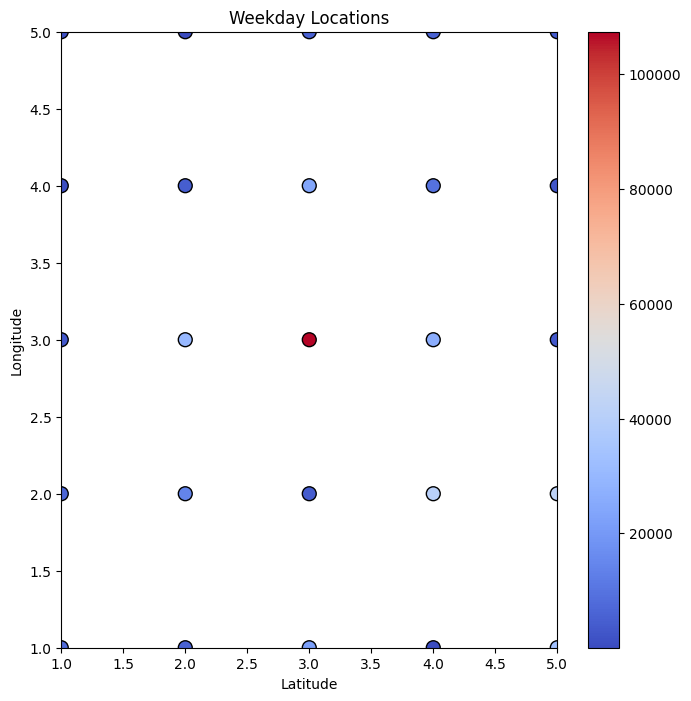

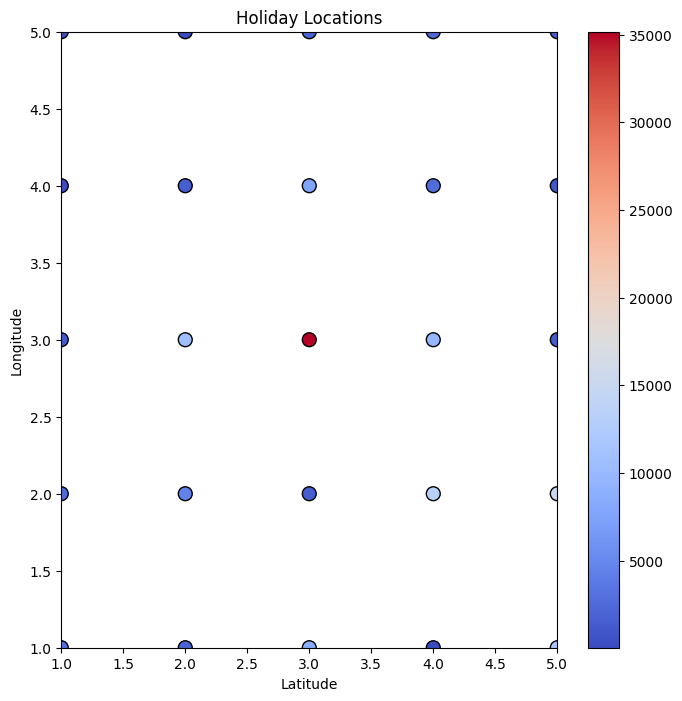

In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

base_date = datetime(2020, 2, 11)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

df_cityD_target = df_cityD_target[df_cityD_target['d']<60]

# x, y をメッシュに基づいて 100x100 にまとめる
df_cityD_target['x_sum_100'] = np.ceil(df_cityD_target['x'] / 2).astype(int)
df_cityD_target['y_sum_100'] = np.ceil(df_cityD_target['y'] / 2).astype(int)

# x, y をメッシュに基づいて 50x50 にまとめる
df_cityD_target['x_sum_50'] = np.ceil(df_cityD_target['x'] / 4).astype(int)
df_cityD_target['y_sum_50'] = np.ceil(df_cityD_target['y'] / 4).astype(int)

# x, y をメッシュに基づいて 25x25 にまとめる
df_cityD_target['x_sum_25'] = np.ceil(df_cityD_target['x'] / 8).astype(int)
df_cityD_target['y_sum_25'] = np.ceil(df_cityD_target['y'] / 8).astype(int)

# x, y をメッシュに基づいて 5x5 にまとめる
df_cityD_target['x_sum_5'] = np.ceil(df_cityD_target['x'] / 40).astype(int)
df_cityD_target['y_sum_5'] = np.ceil(df_cityD_target['y'] / 40).astype(int)

def plot_map(df):
    # フラグに応じてフィルタリングとプロット
    plt.figure(figsize=(12, 8))

    flags = {
        'weekday_flag': 'Weekday',
        'weekend_flag': 'Holiday',
        # 'holiday_flag': 'Special Holiday'
    }
    
    for flag, title in flags.items():
        # 該当フラグが立っている行だけをフィルタリング
        subset = df[df[flag] == 1]
        
        # x, yごとにカウント数を計算
        counts = subset.groupby(['x_sum_5', 'y_sum_5']).size().reset_index(name='count')
        
        # 散布図をプロット（カウント数に基づく色づけ）
        plt.figure(figsize=(8, 8))  # 正方形の図
        scatter = plt.scatter(x=counts['x_sum_5'], y=counts['y_sum_5'], c=counts['count'], cmap='coolwarm', s=100, edgecolor='black')
        plt.colorbar(scatter)
        plt.title(f'{title} Locations')
        plt.xlabel('Latitude')
        plt.ylabel('Longitude')
        plt.xlim(1, 5)
        plt.ylim(1, 5)
        
        # プロットを表示
        plt.show()

plot_map(df_cityD_target)

In [234]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)

def model_xy_5(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_5']
    y_y = data['y_sum_5']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y
    
def model_xy_25(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_25']
    y_y = data['y_sum_25']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)
            
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy_50(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_50']
    y_y = data['y_sum_50']

    model_x = None
    model_y = None
    
    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)
            
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy_100(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_100']
    y_y = data['y_sum_100']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)
            
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

print('reading learning function...')

# 予測値の関数を作成
# def predict_xy(features, model_x, model_y):

#     pred_x = model_x.predict(features)
#     pred_y = model_y.predict(features)
#     return pred_x, pred_y

def predict_xy(features, model_x=None, model_y=None):
    pred_x = None
    pred_y = None
    
    if model_x is not None:
        pred_x = model_x.predict(features)
    
    if model_y is not None:
        pred_y = model_y.predict(features)
    
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    datas = data.copy()

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (datas['uid'] == uid) & (datas['x'] == 999) & (datas['y'] == 999)
        generated_rows = datas[mask]

        generated_rows = generated_rows.copy()
        generated_rows.loc[:, 'x_pred'] = np.nan
        generated_rows.loc[:, 'y_pred'] = np.nan
        generated_rows.loc[:, 'x_sum_5'] = np.nan
        generated_rows.loc[:, 'y_sum_5'] = np.nan
        generated_rows.loc[:, 'x_sum_25'] = np.nan
        generated_rows.loc[:, 'y_sum_25'] = np.nan
        generated_rows.loc[:, 'x_sum_50'] = np.nan
        generated_rows.loc[:, 'y_sum_50'] = np.nan
        generated_rows.loc[:, 'x_sum_100'] = np.nan
        generated_rows.loc[:, 'y_sum_100'] = np.nan

        data = datas[(datas['uid'] == uid) & (datas['x'] != 999) & (datas['y'] != 999)]

        if model_name == 'TabPFN':
            data = data.tail(1000)

        if len(generated_rows)>0:
            ##=========== x_sum_5用、y_sum_5用 ===========##
            # x_sum_5 の値が一つしかない場合、その値をすべての行に適用
            unique_x_sum_5_values = data['x_sum_5'].unique()
            unique_y_sum_5_values = data['y_sum_5'].unique()
            if (len(unique_x_sum_5_values) == 1) and (len(unique_y_sum_5_values) != 1):
                fixed_value = unique_x_sum_5_values[0]
                generated_rows.loc[:, 'x_sum_5'] = fixed_value

                _, model_y_5 = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    _, avg_y_5 = predict_xy(features.values.reshape(1, -1), None, model_y_5)
                    # xとyの値を四捨五入して整数値に変換
                    avg_y_5 = np.where(avg_y_5 < 1, 1, np.where(avg_y_5 > 5, 5, avg_y_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'y_sum_5'] = avg_y_5[0]
            
            elif (len(unique_x_sum_5_values) != 1) and (len(unique_y_sum_5_values) == 1):
                fixed_value = unique_y_sum_5_values[0]
                generated_rows.loc[:, 'y_sum_5'] = fixed_value

                model_x_5, _ = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x_5, _ = predict_xy(features.values.reshape(1, -1), model_x_5, None)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x_5 = np.where(avg_x_5 < 1, 1, np.where(avg_x_5 > 5, 5, avg_x_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'x_sum_5'] = avg_x_5[0]

            elif (len(unique_x_sum_5_values) == 1) and (len(unique_y_sum_5_values) == 1):
                fixed_value = unique_x_sum_5_values[0]
                generated_rows.loc[:, 'x_sum_5'] = fixed_value
                fixed_value = unique_y_sum_5_values[0]
                generated_rows.loc[:, 'y_sum_5'] = fixed_value
                
            else:
                model_x_5, model_y_5 = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x_5, avg_y_5 = predict_xy(features.values.reshape(1, -1), model_x_5, model_y_5)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x_5 = np.where(avg_x_5 < 1, 1, np.where(avg_x_5 > 5, 5, avg_x_5.round().astype(int)))
                    avg_y_5 = np.where(avg_y_5 < 1, 1, np.where(avg_y_5 > 5, 5, avg_y_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'x_sum_5'] = avg_x_5[0]
                    generated_rows.loc[index, 'y_sum_5'] = avg_y_5[0]

            # print("generated_rows.loc[:, 'y_sum_5']:", generated_rows.loc[:, 'y_sum_5'])

            ##=========== x_sum_25用、y_sum_25用 ===========##
            # x_sum_5 の値ごとにデータフレームを分割して x_sum_25 を予測
            df_dict_x_5 = {x_sum_5_value: df for x_sum_5_value, df in generated_rows.groupby('x_sum_5')}

            if not df_dict_x_5:
                print("df_dict_x_5 is empty")
            
            for x_sum_5_value, df_group in df_dict_x_5.items():
                # data を x_sum_5 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_5'] == x_sum_5_value]

                # x_sum_25 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_25_values = filtered_data['x_sum_25'].unique()
                if len(unique_x_sum_25_values) == 1:
                    fixed_value = unique_x_sum_25_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_25'] = fixed_value

                else:    
                    # x_sum_25 の予測モデルを再構築（必要に応じて）
                    model_x_25, _ = model_xy_25(uid, filtered_data, col_list, model_name)
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_25 = predict_xy(features.values.reshape(1, -1), model_x_25, None)[0]  # x のみ予測
                
                        # x の値を四捨五入して整数値に変換
                        avg_x_25 = np.where(avg_x_25 < 1, 1, np.where(avg_x_25 > 25, 25, avg_x_25.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_25'] = avg_x_25
            
            # y_sum_5 の値ごとにデータフレームを分割して y_sum_25 を予測
            df_dict_y_5 = {y_sum_5_value: df for y_sum_5_value, df in generated_rows.groupby('y_sum_5')}

            if not df_dict_y_5:
                print("df_dict_y_5 is empty")
            
            for y_sum_5_value, df_group in df_dict_y_5.items():
                # data を y_sum_5 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_5'] == y_sum_5_value]
                
                # y_sum_25 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_25_values = filtered_data['y_sum_25'].unique()
                if len(unique_y_sum_25_values) == 1:
                    fixed_value = unique_y_sum_25_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_25'] = fixed_value

                else: 
                    # y_sum_25 の予測モデルを再構築（必要に応じて）
                    _, model_y_25 = model_xy_25(uid, filtered_data, col_list, model_name)
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_25 = predict_xy(features.values.reshape(1, -1), None, model_y_25)[1]  # y のみ予測
                
                        # y の値を四捨五入して整数値に変換
                        avg_y_25 = np.where(avg_y_25 < 1, 1, np.where(avg_y_25 > 25, 25, avg_y_25.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_25'] = avg_y_25

            ##=========== x_sum_50用、y_sum_50用 ===========##
            # x_sum_25 の値ごとにデータフレームを分割して x_sum_50 を予測
            df_dict_x_25 = {x_sum_25_value: df for x_sum_25_value, df in generated_rows.groupby('x_sum_25')}

            if not df_dict_x_25:
                print("df_dict_x_25 is empty")
                
            for x_sum_25_value, df_group in df_dict_x_25.items():
                # data を x_sum_25 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_25'] == x_sum_25_value]

                # x_sum_50 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_50_values = filtered_data['x_sum_50'].unique()
                if len(unique_x_sum_50_values) == 1:
                    fixed_value = unique_x_sum_50_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_50'] = fixed_value

                else:
                    # x_sum_50 の予測モデルを再構築（必要に応じて）
                    model_x_50, _ = model_xy_50(uid, filtered_data, col_list, model_name)
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_50 = predict_xy(features.values.reshape(1, -1), model_x_50, None)[0]  # x のみ予測
                
                        # x の値を四捨五入して整数値に変換
                        avg_x_50 = np.where(avg_x_50 < 1, 1, np.where(avg_x_50 > 50, 50, avg_x_50.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_50'] = avg_x_50
            
            # y_sum_25 の値ごとにデータフレームを分割して y_sum_50 を予測
            df_dict_y_25 = {y_sum_25_value: df for y_sum_25_value, df in generated_rows.groupby('y_sum_25')}

            if not df_dict_y_25:
                print("df_dict_y_25 is empty")
                
            for y_sum_25_value, df_group in df_dict_y_25.items():
                # data を y_sum_25 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_25'] == y_sum_25_value]

                # y_sum_50 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_50_values = filtered_data['y_sum_50'].unique()
                if len(unique_y_sum_50_values) == 1:
                    fixed_value = unique_y_sum_50_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_50'] = fixed_value

                else: 
                    # y_sum_50 の予測モデルを再構築（必要に応じて）
                    _, model_y_50 = model_xy_50(uid, filtered_data, col_list, model_name)
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_50 = predict_xy(features.values.reshape(1, -1), None, model_y_50)[1]  # y のみ予測
                
                        # y の値を四捨五入して整数値に変換
                        avg_y_50 = np.where(avg_y_50 < 1, 1, np.where(avg_y_50 > 50, 50, avg_y_50.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_50'] = avg_y_50

            ##=========== x_sum_100用、y_sum_100用 ===========##
            # x_sum_50 の値ごとにデータフレームを分割して x_sum_100 を予測
            df_dict_x_50 = {x_sum_50_value: df for x_sum_50_value, df in generated_rows.groupby('x_sum_50')}

            if not df_dict_x_50:
                print("df_dict_x_50 is empty")
                
            for x_sum_50_value, df_group in df_dict_x_50.items():
                # data を x_sum_50 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_50'] == x_sum_50_value]

                # x_sum_100 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_100_values = filtered_data['x_sum_100'].unique()
                if len(unique_x_sum_100_values) == 1:
                    fixed_value = unique_x_sum_100_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_100'] = fixed_value

                else: 
                    # x_sum_100 の予測モデルを再構築（必要に応じて）
                    model_x_100, _ = model_xy_100(uid, filtered_data, col_list, model_name)
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_100 = predict_xy(features.values.reshape(1, -1), model_x_100, None)[0]  # x のみ予測
                
                        # x の値を四捨五入して整数値に変換
                        avg_x_100 = np.where(avg_x_100 < 1, 1, np.where(avg_x_100 > 100, 100, avg_x_100.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_100'] = avg_x_100
            
            # y_sum_50 の値ごとにデータフレームを分割して y_sum_100 を予測
            df_dict_y_50 = {y_sum_50_value: df for y_sum_50_value, df in generated_rows.groupby('y_sum_50')}

            if not df_dict_y_50:
                print("df_dict_y_50 is empty")
                
            for y_sum_50_value, df_group in df_dict_y_50.items():
                # data を y_sum_50 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_50'] == y_sum_50_value]

                # y_sum_100 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_100_values = filtered_data['y_sum_100'].unique()
                if len(unique_y_sum_100_values) == 1:
                    fixed_value = unique_y_sum_100_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_100'] = fixed_value

                else: 
                    # y_sum_100 の予測モデルを再構築（必要に応じて）
                    _, model_y_100 = model_xy_100(uid, filtered_data, col_list, model_name)
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_100 = predict_xy(features.values.reshape(1, -1), None, model_y_100)[1]  # y のみ予測
                
                        # y の値を四捨五入して整数値に変換
                        avg_y_100 = np.where(avg_y_100 < 1, 1, np.where(avg_y_100 > 100, 100, avg_y_100.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_100'] = avg_y_100

            ##=========== x用、y用 ===========##
            # x_sum_100 の値ごとにデータフレームを分割して x を予測
            df_dict_x_100 = {x_sum_100_value: df for x_sum_100_value, df in generated_rows.groupby('x_sum_100')}
         
            if not df_dict_x_100:
                print("df_dict_x_100 is empty")
                
            for x_sum_100_value, df_group in df_dict_x_100.items():
                # data を x_sum_100 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_100'] == x_sum_100_value]

                # x の値が一つしかない場合、その値をすべての行に適用
                unique_x_values = filtered_data['x'].unique()
                if len(unique_x_values) == 1:
                    fixed_value = unique_x_values[0]
                    generated_rows.loc[df_group.index, 'x_pred'] = fixed_value

                else: 
                    # x の予測モデルを再構築（必要に応じて）
                    model_x, _ = model_xy(uid, filtered_data, col_list, model_name)
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x = predict_xy(features.values.reshape(1, -1), model_x, None)[0]  # x のみ予測
                
                        # x の値を四捨五入して整数値に変換
                        avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_pred'] = avg_x
            
            # y_sum_100 の値ごとにデータフレームを分割して y_sum_100 を予測
            df_dict_y_100 = {y_sum_100_value: df for y_sum_100_value, df in generated_rows.groupby('y_sum_100')}

            if not df_dict_y_100:
                print("df_dict_y_100 is empty")
                
            for y_sum_100_value, df_group in df_dict_y_100.items():
                # data を y_sum_100 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_100'] == y_sum_100_value]

                # y の値が一つしかない場合、その値をすべての行に適用
                unique_y_values = filtered_data['y'].unique()
                if len(unique_y_values) == 1:
                    fixed_value = unique_y_values[0]
                    generated_rows.loc[df_group.index, 'y_pred'] = fixed_value

                else: 
                    # y の予測モデルを再構築（必要に応じて）
                    _, model_y = model_xy(uid, filtered_data, col_list, model_name)
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y = predict_xy(features.values.reshape(1, -1), None, model_y)[1]  # y のみ予測
                
                        # y の値を四捨五入して整数値に変換
                        avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_pred'] = avg_y

            if (generated_rows['uid'] == 439).any():
                print("Generated rows with uid 439:")
                print(generated_rows[generated_rows['uid'] == 439])
            else:
                pass

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                x = row['x_pred']
                y = row['y_pred']

                # データを整形してリストに追加
                generated.append((d, t, x, y)) 
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        # d と t でソートする
        sorted_generated = sorted(generated, key=lambda x: (x[0], x[1]))
        sorted_reference = sorted(reference, key=lambda x: (x[0], x[1]))

        generated = sorted_generated
        reference = sorted_reference

        # 処理4: 評価指標の計算
        geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
        dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
        geobleu_vals.append(geobleu_val)
        dtw_vals.append(dtw_val)

        print('Geobleu:', geobleu_val)
        print('DTW:', dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [13]:
# ラベルエンコーディング修正（処理ごとに0始まり）バージョン

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import logging
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import torch
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier

# 警告を無視する設定
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def set_random_seed(seed: int = 42):
    # set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

def model_xy_5(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_5']
    y_y = data['y_sum_5']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y
    
def model_xy_25(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_25']
    y_y = data['y_sum_25']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
    
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy_50(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_50']
    y_y = data['y_sum_50']

    model_x = None
    model_y = None
    
    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
        
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy_100(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_100']
    y_y = data['y_sum_100']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
        
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
        
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

print('reading learning function...')

# 予測値の関数を作成
# def predict_xy(features, model_x, model_y):

#     pred_x = model_x.predict(features)
#     pred_y = model_y.predict(features)
#     return pred_x, pred_y

def predict_xy(features, model_x=None, model_y=None):
    pred_x = None
    pred_y = None
    
    if model_x is not None:
        pred_x = model_x.predict(features)
    
    if model_y is not None:
        pred_y = model_y.predict(features)
    
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    datas = data.copy()

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (datas['uid'] == uid) & (datas['x'] == 999) & (datas['y'] == 999)
        generated_rows = datas[mask]

        generated_rows = generated_rows.copy()
        generated_rows.loc[:, 'x_pred'] = np.nan
        generated_rows.loc[:, 'y_pred'] = np.nan
        generated_rows.loc[:, 'x_sum_5'] = np.nan
        generated_rows.loc[:, 'y_sum_5'] = np.nan
        generated_rows.loc[:, 'x_sum_25'] = np.nan
        generated_rows.loc[:, 'y_sum_25'] = np.nan
        generated_rows.loc[:, 'x_sum_50'] = np.nan
        generated_rows.loc[:, 'y_sum_50'] = np.nan
        generated_rows.loc[:, 'x_sum_100'] = np.nan
        generated_rows.loc[:, 'y_sum_100'] = np.nan

        data = datas[(datas['uid'] == uid) & (datas['x'] != 999) & (datas['y'] != 999)]
        # data = data.tail(1000)

        # print('x_sum_5のユニーク数:', data['x_sum_5'].unique())
        # print('y_sum_5のユニーク数:', data['y_sum_5'].unique())

        # if model_name == 'TabPFN':
        #     data = data.tail(1000)

        if len(generated_rows)>0:
            ##=========== x_sum_5用、y_sum_5用 ===========##
            # x_sum_5 の値が一つしかない場合、その値をすべての行に適用
            unique_x_sum_5_values = data['x_sum_5'].unique()
            unique_y_sum_5_values = data['y_sum_5'].unique()
            if (len(unique_x_sum_5_values) == 1) and (len(unique_y_sum_5_values) != 1):
                fixed_value = unique_x_sum_5_values[0]
                generated_rows.loc[:, 'x_sum_5'] = fixed_value

                _, model_y_5 = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    _, avg_y_5 = predict_xy(features.values.reshape(1, -1), None, model_y_5)
                    # xとyの値を四捨五入して整数値に変換
                    avg_y_5 = np.where(avg_y_5 < 1, 1, np.where(avg_y_5 > 5, 5, avg_y_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'y_sum_5'] = avg_y_5[0]
            
            elif (len(unique_x_sum_5_values) != 1) and (len(unique_y_sum_5_values) == 1):
                fixed_value = unique_y_sum_5_values[0]
                generated_rows.loc[:, 'y_sum_5'] = fixed_value

                model_x_5, _ = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x_5, _ = predict_xy(features.values.reshape(1, -1), model_x_5, None)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x_5 = np.where(avg_x_5 < 1, 1, np.where(avg_x_5 > 5, 5, avg_x_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'x_sum_5'] = avg_x_5[0]

            elif (len(unique_x_sum_5_values) == 1) and (len(unique_y_sum_5_values) == 1):
                fixed_value = unique_x_sum_5_values[0]
                generated_rows.loc[:, 'x_sum_5'] = fixed_value
                fixed_value = unique_y_sum_5_values[0]
                generated_rows.loc[:, 'y_sum_5'] = fixed_value
                
            else:
                model_x_5, model_y_5 = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x_5, avg_y_5 = predict_xy(features.values.reshape(1, -1), model_x_5, model_y_5)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x_5 = np.where(avg_x_5 < 1, 1, np.where(avg_x_5 > 5, 5, avg_x_5.round().astype(int)))
                    avg_y_5 = np.where(avg_y_5 < 1, 1, np.where(avg_y_5 > 5, 5, avg_y_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'x_sum_5'] = avg_x_5[0]
                    generated_rows.loc[index, 'y_sum_5'] = avg_y_5[0]

            # print("generated_rows.loc[:, 'y_sum_5']:", generated_rows.loc[:, 'y_sum_5'])

            ##=========== x_sum_25用、y_sum_25用 ===========##
            # x_sum_5 の値ごとにデータフレームを分割して x_sum_25 を予測
            df_dict_x_5 = {x_sum_5_value: df for x_sum_5_value, df in generated_rows.groupby('x_sum_5')}

            if not df_dict_x_5:
                print("df_dict_x_5 is empty")
            
            for x_sum_5_value, df_group in df_dict_x_5.items():
                # data を x_sum_5 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_5'] == x_sum_5_value]

                # x_sum_25 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_25_values = filtered_data['x_sum_25'].unique()
                if len(unique_x_sum_25_values) == 1:
                    fixed_value = unique_x_sum_25_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_25'] = fixed_value

                else:    
                    # x_sum_25 の予測モデルを再構築（必要に応じて）
                    # ラベルをエンコード（0開始に変換）
                    label_encoder_x = LabelEncoder()
                    filtered_data['x_sum_25'] = label_encoder_x.fit_transform(filtered_data['x_sum_25'])
                    # print('x_sum_25のユニーク数:', filtered_data['x_sum_25'].unique())
                    model_x_25, _ = model_xy_25(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_25 = predict_xy(features.values.reshape(1, -1), model_x_25, None)[0]  # x のみ予測

                        # 予測後、ラベルを元の形式に戻す
                        avg_x_25 = label_encoder_x.inverse_transform(avg_x_25)
                                        
                        # x の値を四捨五入して整数値に変換
                        avg_x_25 = np.where(avg_x_25 < 1, 1, np.where(avg_x_25 > 25, 25, avg_x_25.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_25'] = avg_x_25
            
            # y_sum_5 の値ごとにデータフレームを分割して y_sum_25 を予測
            df_dict_y_5 = {y_sum_5_value: df for y_sum_5_value, df in generated_rows.groupby('y_sum_5')}

            if not df_dict_y_5:
                print("df_dict_y_5 is empty")
            
            for y_sum_5_value, df_group in df_dict_y_5.items():
                # data を y_sum_5 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_5'] == y_sum_5_value]
                
                # y_sum_25 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_25_values = filtered_data['y_sum_25'].unique()
                if len(unique_y_sum_25_values) == 1:
                    fixed_value = unique_y_sum_25_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_25'] = fixed_value

                else: 
                    # y_sum_25 の予測モデルを再構築（必要に応じて）
                    label_encoder_y = LabelEncoder()
                    filtered_data['y_sum_25'] = label_encoder_y.fit_transform(filtered_data['y_sum_25'])
                    # print('y_sum_25のユニーク数:', filtered_data['y_sum_25'].unique())
                    _, model_y_25 = model_xy_25(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_25 = predict_xy(features.values.reshape(1, -1), None, model_y_25)[1]  # y のみ予測

                        # 予測後、ラベルを元の形式に戻す
                        avg_y_25 = label_encoder_y.inverse_transform(avg_y_25)
                
                        # y の値を四捨五入して整数値に変換
                        avg_y_25 = np.where(avg_y_25 < 1, 1, np.where(avg_y_25 > 25, 25, avg_y_25.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_25'] = avg_y_25

            ##=========== x_sum_50用、y_sum_50用 ===========##
            # x_sum_25 の値ごとにデータフレームを分割して x_sum_50 を予測
            df_dict_x_25 = {x_sum_25_value: df for x_sum_25_value, df in generated_rows.groupby('x_sum_25')}

            if not df_dict_x_25:
                print("df_dict_x_25 is empty")
                
            for x_sum_25_value, df_group in df_dict_x_25.items():
                # data を x_sum_25 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_25'] == x_sum_25_value]

                # x_sum_50 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_50_values = filtered_data['x_sum_50'].unique()
                if len(unique_x_sum_50_values) == 1:
                    fixed_value = unique_x_sum_50_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_50'] = fixed_value

                else:
                    # x_sum_50 の予測モデルを再構築（必要に応じて）
                    label_encoder_x = LabelEncoder()
                    filtered_data['x_sum_50'] = label_encoder_x.fit_transform(filtered_data['x_sum_50'])
                    # print('x_sum_50のユニーク数:', filtered_data['x_sum_50'].unique())
                    model_x_50, _ = model_xy_50(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_50 = predict_xy(features.values.reshape(1, -1), model_x_50, None)[0]  # x のみ予測

                        # 予測後、ラベルを元の形式に戻す
                        avg_x_50 = label_encoder_x.inverse_transform(avg_x_50)
                
                        # x の値を四捨五入して整数値に変換
                        avg_x_50 = np.where(avg_x_50 < 1, 1, np.where(avg_x_50 > 50, 50, avg_x_50.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_50'] = avg_x_50
            
            # y_sum_25 の値ごとにデータフレームを分割して y_sum_50 を予測
            df_dict_y_25 = {y_sum_25_value: df for y_sum_25_value, df in generated_rows.groupby('y_sum_25')}

            if not df_dict_y_25:
                print("df_dict_y_25 is empty")
                
            for y_sum_25_value, df_group in df_dict_y_25.items():
                # data を y_sum_25 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_25'] == y_sum_25_value]

                # y_sum_50 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_50_values = filtered_data['y_sum_50'].unique()
                if len(unique_y_sum_50_values) == 1:
                    fixed_value = unique_y_sum_50_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_50'] = fixed_value

                else: 
                    # y_sum_50 の予測モデルを再構築（必要に応じて）
                    label_encoder_y = LabelEncoder()
                    filtered_data['y_sum_50'] = label_encoder_y.fit_transform(filtered_data['y_sum_50'])
                    # print('y_sum_50のユニーク数:', filtered_data['y_sum_50'].unique())
                    _, model_y_50 = model_xy_50(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_50 = predict_xy(features.values.reshape(1, -1), None, model_y_50)[1]  # y のみ予測
                        # 予測後、ラベルを元の形式に戻す
                        avg_y_50 = label_encoder_y.inverse_transform(avg_y_50)
                
                        # y の値を四捨五入して整数値に変換
                        avg_y_50 = np.where(avg_y_50 < 1, 1, np.where(avg_y_50 > 50, 50, avg_y_50.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_50'] = avg_y_50

            ##=========== x_sum_100用、y_sum_100用 ===========##
            # x_sum_50 の値ごとにデータフレームを分割して x_sum_100 を予測
            df_dict_x_50 = {x_sum_50_value: df for x_sum_50_value, df in generated_rows.groupby('x_sum_50')}

            if not df_dict_x_50:
                print("df_dict_x_50 is empty")
                
            for x_sum_50_value, df_group in df_dict_x_50.items():
                # data を x_sum_50 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_50'] == x_sum_50_value]

                # x_sum_100 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_100_values = filtered_data['x_sum_100'].unique()
                if len(unique_x_sum_100_values) == 1:
                    fixed_value = unique_x_sum_100_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_100'] = fixed_value

                else: 
                    # x_sum_100 の予測モデルを再構築（必要に応じて）
                    label_encoder_x = LabelEncoder()
                    filtered_data['x_sum_100'] = label_encoder_x.fit_transform(filtered_data['x_sum_100'])
                    # print('x_sum_100のユニーク数:', filtered_data['x_sum_100'].unique())
                    model_x_100, _ = model_xy_100(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_100 = predict_xy(features.values.reshape(1, -1), model_x_100, None)[0]  # x のみ予測
                        
                        # 予測後、ラベルを元の形式に戻す
                        avg_x_100 = label_encoder_x.inverse_transform(avg_x_100)
                        
                        # x の値を四捨五入して整数値に変換
                        avg_x_100 = np.where(avg_x_100 < 1, 1, np.where(avg_x_100 > 100, 100, avg_x_100.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_100'] = avg_x_100
            
            # y_sum_50 の値ごとにデータフレームを分割して y_sum_100 を予測
            df_dict_y_50 = {y_sum_50_value: df for y_sum_50_value, df in generated_rows.groupby('y_sum_50')}

            if not df_dict_y_50:
                print("df_dict_y_50 is empty")
                
            for y_sum_50_value, df_group in df_dict_y_50.items():
                # data を y_sum_50 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_50'] == y_sum_50_value]
                # print('y_sum_100のユニーク数:', filtered_data['y_sum_100'].unique())

                # y_sum_100 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_100_values = filtered_data['y_sum_100'].unique()
                if len(unique_y_sum_100_values) == 1:
                    fixed_value = unique_y_sum_100_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_100'] = fixed_value

                else: 
                    # y_sum_100 の予測モデルを再構築（必要に応じて）
                    label_encoder_y = LabelEncoder()
                    filtered_data['y_sum_100'] = label_encoder_y.fit_transform(filtered_data['y_sum_100'])
                    # print('y_sum_100のユニーク数:', filtered_data['y_sum_100'].unique())
                    _, model_y_100 = model_xy_100(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_100 = predict_xy(features.values.reshape(1, -1), None, model_y_100)[1]  # y のみ予測
                        
                        # 予測後、ラベルを元の形式に戻す
                        avg_y_100 = label_encoder_y.inverse_transform(avg_y_100)
                        
                        # y の値を四捨五入して整数値に変換
                        avg_y_100 = np.where(avg_y_100 < 1, 1, np.where(avg_y_100 > 100, 100, avg_y_100.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_100'] = avg_y_100

            ##=========== x用、y用 ===========##
            # x_sum_100 の値ごとにデータフレームを分割して x を予測
            df_dict_x_100 = {x_sum_100_value: df for x_sum_100_value, df in generated_rows.groupby('x_sum_100')}
         
            if not df_dict_x_100:
                print("df_dict_x_100 is empty")
                
            for x_sum_100_value, df_group in df_dict_x_100.items():
                # data を x_sum_100 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_100'] == x_sum_100_value]

                # x の値が一つしかない場合、その値をすべての行に適用
                unique_x_values = filtered_data['x'].unique()
                if len(unique_x_values) == 1:
                    fixed_value = unique_x_values[0]
                    generated_rows.loc[df_group.index, 'x_pred'] = fixed_value

                else: 
                    # x の予測モデルを再構築（必要に応じて）
                    label_encoder_x = LabelEncoder()
                    filtered_data['x'] = label_encoder_x.fit_transform(filtered_data['x'])
                    # print('xのユニーク数:', filtered_data['x'].unique())
                    model_x, _ = model_xy(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x = predict_xy(features.values.reshape(1, -1), model_x, None)[0]  # x のみ予測
                        
                        # 予測後、ラベルを元の形式に戻す
                        avg_x = label_encoder_x.inverse_transform(avg_x)
                        
                        # x の値を四捨五入して整数値に変換
                        avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_pred'] = avg_x
            
            # y_sum_100 の値ごとにデータフレームを分割して y_sum_100 を予測
            df_dict_y_100 = {y_sum_100_value: df for y_sum_100_value, df in generated_rows.groupby('y_sum_100')}

            if not df_dict_y_100:
                print("df_dict_y_100 is empty")
                
            for y_sum_100_value, df_group in df_dict_y_100.items():
                # data を y_sum_100 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_100'] == y_sum_100_value]

                # y の値が一つしかない場合、その値をすべての行に適用
                unique_y_values = filtered_data['y'].unique()
                if len(unique_y_values) == 1:
                    fixed_value = unique_y_values[0]
                    generated_rows.loc[df_group.index, 'y_pred'] = fixed_value

                else: 
                    # y の予測モデルを再構築（必要に応じて）
                    label_encoder_y = LabelEncoder()
                    filtered_data['y'] = label_encoder_y.fit_transform(filtered_data['y'])
                    # print('yのユニーク数:', filtered_data['y'].unique())
                    _, model_y = model_xy(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y = predict_xy(features.values.reshape(1, -1), None, model_y)[1]  # y のみ予測
                        
                        # 予測後、ラベルを元の形式に戻す
                        avg_y = label_encoder_x.inverse_transform(avg_y)
                        
                        # y の値を四捨五入して整数値に変換
                        avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_pred'] = avg_y

            if (generated_rows['uid'] == 439).any():
                print("Generated rows with uid 439:")
                print(generated_rows[generated_rows['uid'] == 439])
            else:
                pass

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                x = row['x_pred']
                y = row['y_pred']

                # データを整形してリストに追加
                generated.append((d, t, x, y)) 
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        # d と t でソートする
        sorted_generated = sorted(generated, key=lambda x: (x[0], x[1]))
        sorted_reference = sorted(reference, key=lambda x: (x[0], x[1]))

        generated = sorted_generated
        reference = sorted_reference

        # 処理4: 評価指標の計算
        geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
        dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
        geobleu_vals.append(geobleu_val)
        dtw_vals.append(dtw_val)

        print('Geobleu:', geobleu_val)
        print('DTW:', dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [232]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

# df_cityD_target['d'] < 60 の条件を満たすときのみメッシュを計算し、それ以外は NaN
df_cityD_target['x_sum_100'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 2).astype(int), np.nan)
df_cityD_target['y_sum_100'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 2).astype(int), np.nan)

df_cityD_target['x_sum_50'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 4).astype(int), np.nan)
df_cityD_target['y_sum_50'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 4).astype(int), np.nan)

df_cityD_target['x_sum_25'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 8).astype(int), np.nan)
df_cityD_target['y_sum_25'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 8).astype(int), np.nan)

df_cityD_target['x_sum_5'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 40).astype(int), np.nan)
df_cityD_target['y_sum_5'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 40).astype(int), np.nan)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
Geobleu: 0.03419807362403058
DTW: 63.93134947186331
uid: 14
Geobleu: 0.039082502146302815
DTW: 125.89537394308942
uid: 29
Geobleu: 0.01049858479130432
DTW: 103.64660100631663
uid: 30
Geobleu: 0.22945630635922173
DTW: 15.793846629788304
uid: 32
Geobleu: 0.41048034455694
DTW: 11.499745012700988
uid: 43
Geobleu: 0.3267780933740429
DTW: 51.74093705150595
uid: 44
Geobleu: 0.38425046237295996
DTW: 3.2158536320184266
uid: 45
Geobleu: 0.3988906696575579
DTW: 20.643776172323008
uid: 51
Geobleu: 0.701413227770612
DTW: 14.719559650112298
uid: 52
Geobleu: 0.3275247911568011
DTW: 29.639818725661804
uid: 56
Geobleu: 0.1708708601998114
DTW: 24.214939490812533
uid: 63
Geobleu: 0.012663582086698589
DTW: 52.348044699813045
uid: 67
Geobleu: 0.0764412908047176
DTW: 32.00437057640882
uid: 70
Geobleu: 0.5269221671091432
DTW: 14.426144921677583
uid: 73
Geobleu: 0.21894203762706893
DTW: 24.084515429107

In [14]:
# Label Encoding version

warnings.simplefilter('ignore')

base_date = datetime(2020, 2, 11)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

# df_cityD_target['d'] < 60 の条件を満たすときのみメッシュを計算し、それ以外は NaN
df_cityD_target['x_sum_100'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 2).astype(int), np.nan)
df_cityD_target['y_sum_100'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 2).astype(int), np.nan)

df_cityD_target['x_sum_50'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 4).astype(int), np.nan)
df_cityD_target['y_sum_50'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 4).astype(int), np.nan)

df_cityD_target['x_sum_25'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 8).astype(int), np.nan)
df_cityD_target['y_sum_25'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 8).astype(int), np.nan)

df_cityD_target['x_sum_5'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 40).astype(int), np.nan)
df_cityD_target['y_sum_5'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 40).astype(int), np.nan)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
Geobleu: 2.9763951432798513e-07
DTW: 467.6360965578697
uid: 14
Geobleu: 0.0069353631342878065
DTW: 139.212420122462
uid: 29
Geobleu: 0.0005071147021826391
DTW: 97.91675625190075
uid: 30
Geobleu: 1.0526496912960406e-48
DTW: 1035.2632712013208
uid: 32
Geobleu: 5.080917422454772e-32
DTW: 1209.6795699190982
uid: 43
Geobleu: 0.033055259084133176
DTW: 162.33656841093256
uid: 44
Geobleu: 2.9865805591586526e-58
DTW: 875.558835476448
uid: 45
Geobleu: 0.012131293488117461
DTW: 78.2204481240681
uid: 51
Geobleu: 3.1511609920689104e-11
DTW: 108.84686179465915
uid: 52
Geobleu: 0.0003514173715954477
DTW: 62.83863250550292
uid: 56
Geobleu: 7.208629824006958e-05
DTW: 102.91025989632388
uid: 63
Geobleu: 0.0019319452640082038
DTW: 150.8580612144639
uid: 67
Geobleu: 6.3706710830011744e-15
DTW: 532.3219843122071
uid: 70
Geobleu: 2.9902395718256525e-35
DTW: 958.3385217806541
uid: 73
Geobleu: 3.407976

KeyboardInterrupt: 

## TabPFN

In [19]:
# ラベルエンコーディング修正（処理ごとに0始まり）バージョン

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import logging
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import torch
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier

# 警告を無視する設定
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def set_random_seed(seed: int = 42):
    # set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

def model_xy_5(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_5']
    y_y = data['y_sum_5']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y
    
def model_xy_25(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_25']
    y_y = data['y_sum_25']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
    
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy_50(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_50']
    y_y = data['y_sum_50']

    model_x = None
    model_y = None
    
    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
        
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy_100(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x_sum_100']
    y_y = data['y_sum_100']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
        
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

def model_xy(uid, data, col_list, model_name, x_fltr, y_fltr):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    model_x = None
    model_y = None

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        if len(y_x.unique()) != 1:
            model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        if len(y_y.unique()) != 1:
            model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        if len(y_x.unique()) != 1:
            model_x = RandomForestClassifier(random_state=42)
        if len(y_y.unique()) != 1:
            model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        if len(y_x.unique()) != 1:
            model_x = LinearRegression()
        if len(y_y.unique()) != 1:
            model_y = LinearRegression()
    elif model_name == 'LGBM':
        if len(y_x.unique()) != 1:
            model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        if len(y_y.unique()) != 1:
            model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        if len(y_x.unique()) != 1:
            model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        if len(y_y.unique()) != 1:
            model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    if x_fltr == 'ok':
        model_x = None
    if y_fltr == 'ok':
        model_y = None
        
    # モデルの学習
    if model_x is not None:
        model_x.fit(X, y_x)
    if model_y is not None:
        model_y.fit(X, y_y)

    return model_x, model_y

print('reading learning function...')

# 予測値の関数を作成
# def predict_xy(features, model_x, model_y):

#     pred_x = model_x.predict(features)
#     pred_y = model_y.predict(features)
#     return pred_x, pred_y

def predict_xy(features, model_x=None, model_y=None):
    pred_x = None
    pred_y = None
    
    if model_x is not None:
        pred_x = model_x.predict(features)
    
    if model_y is not None:
        pred_y = model_y.predict(features)
    
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    datas = data.copy()

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (datas['uid'] == uid) & (datas['x'] == 999) & (datas['y'] == 999)
        generated_rows = datas[mask]

        generated_rows = generated_rows.copy()
        generated_rows.loc[:, 'x_pred'] = np.nan
        generated_rows.loc[:, 'y_pred'] = np.nan
        generated_rows.loc[:, 'x_sum_5'] = np.nan
        generated_rows.loc[:, 'y_sum_5'] = np.nan
        generated_rows.loc[:, 'x_sum_25'] = np.nan
        generated_rows.loc[:, 'y_sum_25'] = np.nan
        generated_rows.loc[:, 'x_sum_50'] = np.nan
        generated_rows.loc[:, 'y_sum_50'] = np.nan
        generated_rows.loc[:, 'x_sum_100'] = np.nan
        generated_rows.loc[:, 'y_sum_100'] = np.nan

        data = datas[(datas['uid'] == uid) & (datas['x'] != 999) & (datas['y'] != 999)]
        data = data.tail(1000)

        # print('x_sum_5のユニーク数:', data['x_sum_5'].unique())
        # print('y_sum_5のユニーク数:', data['y_sum_5'].unique())

        # if model_name == 'TabPFN':
        #     data = data.tail(1000)

        if len(generated_rows)>0:
            ##=========== x_sum_5用、y_sum_5用 ===========##
            # x_sum_5 の値が一つしかない場合、その値をすべての行に適用
            unique_x_sum_5_values = data['x_sum_5'].unique()
            unique_y_sum_5_values = data['y_sum_5'].unique()
            if (len(unique_x_sum_5_values) == 1) and (len(unique_y_sum_5_values) != 1):
                fixed_value = unique_x_sum_5_values[0]
                generated_rows.loc[:, 'x_sum_5'] = fixed_value

                _, model_y_5 = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    _, avg_y_5 = predict_xy(features.values.reshape(1, -1), None, model_y_5)
                    # xとyの値を四捨五入して整数値に変換
                    avg_y_5 = np.where(avg_y_5 < 1, 1, np.where(avg_y_5 > 5, 5, avg_y_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'y_sum_5'] = avg_y_5[0]
            
            elif (len(unique_x_sum_5_values) != 1) and (len(unique_y_sum_5_values) == 1):
                fixed_value = unique_y_sum_5_values[0]
                generated_rows.loc[:, 'y_sum_5'] = fixed_value

                model_x_5, _ = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x_5, _ = predict_xy(features.values.reshape(1, -1), model_x_5, None)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x_5 = np.where(avg_x_5 < 1, 1, np.where(avg_x_5 > 5, 5, avg_x_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'x_sum_5'] = avg_x_5[0]

            elif (len(unique_x_sum_5_values) == 1) and (len(unique_y_sum_5_values) == 1):
                fixed_value = unique_x_sum_5_values[0]
                generated_rows.loc[:, 'x_sum_5'] = fixed_value
                fixed_value = unique_y_sum_5_values[0]
                generated_rows.loc[:, 'y_sum_5'] = fixed_value
                
            else:
                model_x_5, model_y_5 = model_xy_5(uid, data, col_list, model_name)
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x_5, avg_y_5 = predict_xy(features.values.reshape(1, -1), model_x_5, model_y_5)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x_5 = np.where(avg_x_5 < 1, 1, np.where(avg_x_5 > 5, 5, avg_x_5.round().astype(int)))
                    avg_y_5 = np.where(avg_y_5 < 1, 1, np.where(avg_y_5 > 5, 5, avg_y_5.round().astype(int)))
    
                    # データフレームに予測結果を格納
                    generated_rows.loc[index, 'x_sum_5'] = avg_x_5[0]
                    generated_rows.loc[index, 'y_sum_5'] = avg_y_5[0]

            # print("generated_rows.loc[:, 'y_sum_5']:", generated_rows.loc[:, 'y_sum_5'])

            ##=========== x_sum_25用、y_sum_25用 ===========##
            # x_sum_5 の値ごとにデータフレームを分割して x_sum_25 を予測
            df_dict_x_5 = {x_sum_5_value: df for x_sum_5_value, df in generated_rows.groupby('x_sum_5')}

            if not df_dict_x_5:
                print("df_dict_x_5 is empty")
            
            for x_sum_5_value, df_group in df_dict_x_5.items():
                # data を x_sum_5 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_5'] == x_sum_5_value]

                # x_sum_25 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_25_values = filtered_data['x_sum_25'].unique()
                if len(unique_x_sum_25_values) == 1:
                    fixed_value = unique_x_sum_25_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_25'] = fixed_value

                else:    
                    # x_sum_25 の予測モデルを再構築（必要に応じて）
                    # ラベルをエンコード（0開始に変換）
                    # print('x_sum_25のユニーク数:', filtered_data['x_sum_25'].unique())
                    model_x_25, _ = model_xy_25(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_25 = predict_xy(features.values.reshape(1, -1), model_x_25, None)[0]  # x のみ予測
                                        
                        # x の値を四捨五入して整数値に変換
                        avg_x_25 = np.where(avg_x_25 < 1, 1, np.where(avg_x_25 > 25, 25, avg_x_25.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_25'] = avg_x_25
            
            # y_sum_5 の値ごとにデータフレームを分割して y_sum_25 を予測
            df_dict_y_5 = {y_sum_5_value: df for y_sum_5_value, df in generated_rows.groupby('y_sum_5')}

            if not df_dict_y_5:
                print("df_dict_y_5 is empty")
            
            for y_sum_5_value, df_group in df_dict_y_5.items():
                # data を y_sum_5 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_5'] == y_sum_5_value]
                
                # y_sum_25 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_25_values = filtered_data['y_sum_25'].unique()
                if len(unique_y_sum_25_values) == 1:
                    fixed_value = unique_y_sum_25_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_25'] = fixed_value

                else: 
                    # y_sum_25 の予測モデルを再構築（必要に応じて）
                    # print('y_sum_25のユニーク数:', filtered_data['y_sum_25'].unique())
                    _, model_y_25 = model_xy_25(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_25 = predict_xy(features.values.reshape(1, -1), None, model_y_25)[1]  # y のみ予測
                
                        # y の値を四捨五入して整数値に変換
                        avg_y_25 = np.where(avg_y_25 < 1, 1, np.where(avg_y_25 > 25, 25, avg_y_25.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_25'] = avg_y_25

            ##=========== x_sum_50用、y_sum_50用 ===========##
            # x_sum_25 の値ごとにデータフレームを分割して x_sum_50 を予測
            df_dict_x_25 = {x_sum_25_value: df for x_sum_25_value, df in generated_rows.groupby('x_sum_25')}

            if not df_dict_x_25:
                print("df_dict_x_25 is empty")
                
            for x_sum_25_value, df_group in df_dict_x_25.items():
                # data を x_sum_25 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_25'] == x_sum_25_value]

                # x_sum_50 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_50_values = filtered_data['x_sum_50'].unique()
                if len(unique_x_sum_50_values) == 1:
                    fixed_value = unique_x_sum_50_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_50'] = fixed_value

                else:
                    # print('x_sum_50のユニーク数:', filtered_data['x_sum_50'].unique())
                    model_x_50, _ = model_xy_50(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_50 = predict_xy(features.values.reshape(1, -1), model_x_50, None)[0]  # x のみ予測
                
                        # x の値を四捨五入して整数値に変換
                        avg_x_50 = np.where(avg_x_50 < 1, 1, np.where(avg_x_50 > 50, 50, avg_x_50.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_50'] = avg_x_50
            
            # y_sum_25 の値ごとにデータフレームを分割して y_sum_50 を予測
            df_dict_y_25 = {y_sum_25_value: df for y_sum_25_value, df in generated_rows.groupby('y_sum_25')}

            if not df_dict_y_25:
                print("df_dict_y_25 is empty")
                
            for y_sum_25_value, df_group in df_dict_y_25.items():
                # data を y_sum_25 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_25'] == y_sum_25_value]

                # y_sum_50 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_50_values = filtered_data['y_sum_50'].unique()
                if len(unique_y_sum_50_values) == 1:
                    fixed_value = unique_y_sum_50_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_50'] = fixed_value

                else: 
                    # y_sum_50 の予測モデルを再構築（必要に応じて）
                    # print('y_sum_50のユニーク数:', filtered_data['y_sum_50'].unique())
                    _, model_y_50 = model_xy_50(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_50 = predict_xy(features.values.reshape(1, -1), None, model_y_50)[1]  # y のみ予測
                
                        # y の値を四捨五入して整数値に変換
                        avg_y_50 = np.where(avg_y_50 < 1, 1, np.where(avg_y_50 > 50, 50, avg_y_50.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_50'] = avg_y_50

            ##=========== x_sum_100用、y_sum_100用 ===========##
            # x_sum_50 の値ごとにデータフレームを分割して x_sum_100 を予測
            df_dict_x_50 = {x_sum_50_value: df for x_sum_50_value, df in generated_rows.groupby('x_sum_50')}

            if not df_dict_x_50:
                print("df_dict_x_50 is empty")
                
            for x_sum_50_value, df_group in df_dict_x_50.items():
                # data を x_sum_50 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_50'] == x_sum_50_value]

                # x_sum_100 の値が一つしかない場合、その値をすべての行に適用
                unique_x_sum_100_values = filtered_data['x_sum_100'].unique()
                if len(unique_x_sum_100_values) == 1:
                    fixed_value = unique_x_sum_100_values[0]
                    generated_rows.loc[df_group.index, 'x_sum_100'] = fixed_value

                else: 
                    # x_sum_100 の予測モデルを再構築（必要に応じて）
                    # print('x_sum_100のユニーク数:', filtered_data['x_sum_100'].unique())
                    model_x_100, _ = model_xy_100(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x_100 = predict_xy(features.values.reshape(1, -1), model_x_100, None)[0]  # x のみ予測
                        
                        # x の値を四捨五入して整数値に変換
                        avg_x_100 = np.where(avg_x_100 < 1, 1, np.where(avg_x_100 > 100, 100, avg_x_100.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_sum_100'] = avg_x_100
            
            # y_sum_50 の値ごとにデータフレームを分割して y_sum_100 を予測
            df_dict_y_50 = {y_sum_50_value: df for y_sum_50_value, df in generated_rows.groupby('y_sum_50')}

            if not df_dict_y_50:
                print("df_dict_y_50 is empty")
                
            for y_sum_50_value, df_group in df_dict_y_50.items():
                # data を y_sum_50 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_50'] == y_sum_50_value]
                # print('y_sum_100のユニーク数:', filtered_data['y_sum_100'].unique())

                # y_sum_100 の値が一つしかない場合、その値をすべての行に適用
                unique_y_sum_100_values = filtered_data['y_sum_100'].unique()
                if len(unique_y_sum_100_values) == 1:
                    fixed_value = unique_y_sum_100_values[0]
                    generated_rows.loc[df_group.index, 'y_sum_100'] = fixed_value

                else: 
                    # y_sum_100 の予測モデルを再構築（必要に応じて）
                    # print('y_sum_100のユニーク数:', filtered_data['y_sum_100'].unique())
                    _, model_y_100 = model_xy_100(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y_100 = predict_xy(features.values.reshape(1, -1), None, model_y_100)[1]  # y のみ予測
                        
                        # y の値を四捨五入して整数値に変換
                        avg_y_100 = np.where(avg_y_100 < 1, 1, np.where(avg_y_100 > 100, 100, avg_y_100.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_sum_100'] = avg_y_100

            ##=========== x用、y用 ===========##
            # x_sum_100 の値ごとにデータフレームを分割して x を予測
            df_dict_x_100 = {x_sum_100_value: df for x_sum_100_value, df in generated_rows.groupby('x_sum_100')}
         
            if not df_dict_x_100:
                print("df_dict_x_100 is empty")
                
            for x_sum_100_value, df_group in df_dict_x_100.items():
                # data を x_sum_100 の値に基づいてフィルタリング
                filtered_data = data[data['x_sum_100'] == x_sum_100_value]

                # x の値が一つしかない場合、その値をすべての行に適用
                unique_x_values = filtered_data['x'].unique()
                if len(unique_x_values) == 1:
                    fixed_value = unique_x_values[0]
                    generated_rows.loc[df_group.index, 'x_pred'] = fixed_value

                else: 
                    # x の予測モデルを再構築（必要に応じて）
                    # print('xのユニーク数:', filtered_data['x'].unique())
                    model_x, _ = model_xy(uid, filtered_data, col_list, model_name, 'no', 'ok')
                    
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_x = predict_xy(features.values.reshape(1, -1), model_x, None)[0]  # x のみ予測
                        
                        # x の値を四捨五入して整数値に変換
                        avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'x_pred'] = avg_x
            
            # y_sum_100 の値ごとにデータフレームを分割して y_sum_100 を予測
            df_dict_y_100 = {y_sum_100_value: df for y_sum_100_value, df in generated_rows.groupby('y_sum_100')}

            if not df_dict_y_100:
                print("df_dict_y_100 is empty")
                
            for y_sum_100_value, df_group in df_dict_y_100.items():
                # data を y_sum_100 の値に基づいてフィルタリング
                filtered_data = data[data['y_sum_100'] == y_sum_100_value]

                # y の値が一つしかない場合、その値をすべての行に適用
                unique_y_values = filtered_data['y'].unique()
                if len(unique_y_values) == 1:
                    fixed_value = unique_y_values[0]
                    generated_rows.loc[df_group.index, 'y_pred'] = fixed_value

                else: 
                    # y の予測モデルを再構築（必要に応じて）
                    # print('yのユニーク数:', filtered_data['y'].unique())
                    _, model_y = model_xy(uid, filtered_data, col_list, model_name, 'ok', 'no')
                
                    for index, row in df_group.iterrows():
                        features = row[col_list]
                        avg_y = predict_xy(features.values.reshape(1, -1), None, model_y)[1]  # y のみ予測
                        
                        # y の値を四捨五入して整数値に変換
                        avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))
                
                        # データフレームに予測結果を格納
                        generated_rows.loc[index, 'y_pred'] = avg_y

            if (generated_rows['uid'] == 439).any():
                print("Generated rows with uid 439:")
                print(generated_rows[generated_rows['uid'] == 439])
            else:
                pass

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                x = row['x_pred']
                y = row['y_pred']

                # データを整形してリストに追加
                generated.append((d, t, x, y)) 
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        # d と t でソートする
        sorted_generated = sorted(generated, key=lambda x: (x[0], x[1]))
        sorted_reference = sorted(reference, key=lambda x: (x[0], x[1]))

        generated = sorted_generated
        reference = sorted_reference

        # 処理4: 評価指標の計算
        geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
        dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
        geobleu_vals.append(geobleu_val)
        dtw_vals.append(dtw_val)

        print('Geobleu:', geobleu_val)
        print('DTW:', dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [20]:
from datetime import datetime, timedelta
import jpholiday
import time

warnings.simplefilter('ignore')

base_date = datetime(2020, 2, 11)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

# df_cityD_target['d'] < 60 の条件を満たすときのみメッシュを計算し、それ以外は NaN
df_cityD_target['x_sum_100'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 2).astype(int), np.nan)
df_cityD_target['y_sum_100'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 2).astype(int), np.nan)

df_cityD_target['x_sum_50'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 4).astype(int), np.nan)
df_cityD_target['y_sum_50'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 4).astype(int), np.nan)

df_cityD_target['x_sum_25'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 8).astype(int), np.nan)
df_cityD_target['y_sum_25'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 8).astype(int), np.nan)

df_cityD_target['x_sum_5'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['x'] / 40).astype(int), np.nan)
df_cityD_target['y_sum_5'] = np.where(df_cityD_target['d'] < 60, np.ceil(df_cityD_target['y'] / 40).astype(int), np.nan)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'TabPFN' # SVR, RandomForestRegressor, LinearRegression, LGBM

aa = df_cityD_target[df_cityD_target['uid']==0]
bb = df_cityD_reference[df_cityD_reference['uid']==0]
evaluation(aa, bb, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0


/home/m-suzuki-5y3/myenv/lib/python3.10/site-packages/tabpfn/scripts/transformer_prediction_interface.py:530: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=fp16_inference):
/home/m-suzuki-5y3/myenv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/m-suzuki-5y3/myenv/lib/python3.10/site-packages/tabpfn/scripts/transformer_prediction_interface.py:530: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` 

Geobleu: 0.03692885147170449
DTW: 83.64612969156528
Average geobleu: 0.03692885147170449
Standard deviation geobleu: 0.0
Average dtw: 83.64612969156528
Standard deviation dtw: 0.0
2.26分


# Geobleuスコアが悪いユーザは平均値を入れる

In [210]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y

print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    data_test = data[data['d'] < 60]
    data_train = data_test[data_test['d'] < 45]
    data_valid = data_test[data_test['d'] >= 45]

    geobleu_vals = []
    dtw_vals = []

    # geobleu_val が 0.1 より小さい id を保存するリスト
    ids_with_low_geobleu = []

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 前もって評価しスコアが高いか確認
        mask = (data_test['uid'] == uid) & (data_test['d'] >= 45)
        generated_rows = data_test[mask]
         
        if len(generated_rows)>0:
            if data_train[data_train['uid'] == uid].empty:
                pass
            else:
                model_x, model_y = model_xy(uid, data_train, col_list, model_name)
    
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                    avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))
    
                    # データを整形してリストに追加
                    generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                    reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                    if not reference_row.empty:
                        reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))
            
                if len(generated_rows) > 0:
                    # 処理4: 評価指標の計算
                    # geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
                    dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
                    if dtw_val >= 90: # 平均値
                    # if geobleu_val < 0.05: # 平均値
                        ids_with_low_geobleu.append(uid)

        # 予測本番
        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]
        
        if len(generated_rows)>0:
            if uid in ids_with_low_geobleu:
                # x と y が 999 でない行の x と y の平均値を計算
                subset = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]
                t_grouped = subset.groupby('t')
        
                # 時間 t ごとの平均値 or 最頻値を計算
                # avg_x_per_t = t_grouped['x'].mean().round().clip(1, 200)
                # avg_y_per_t = t_grouped['y'].mean().round().clip(1, 200)
                avg_x_per_t = t_grouped['x'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).round().clip(1, 200)
                avg_y_per_t = t_grouped['y'].agg(lambda y: y.mode().iloc[0] if not y.mode().empty else np.nan).round().clip(1, 200)

                avg_x_defo = subset['x'].mean()
                avg_y_defo = subset['y'].mean()
                # 四捨五入して整数値に変換
                avg_x_defo = np.clip(round(avg_x_defo), 1, 200)
                avg_y_defo = np.clip(round(avg_y_defo), 1, 200)
        
                # 平均値を generated に追加
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
        
                    # 該当する時間 t の平均値を取得
                    avg_x = avg_x_per_t.get(t, avg_x_defo)
                    avg_y = avg_y_per_t.get(t, avg_y_defo)
                    generated.append((d, t, avg_x, avg_y))
                    reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                    if not reference_row.empty:
                        reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))
            else:
                model_x, model_y = model_xy(uid, data, col_list, model_name)
    
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                    avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))
    
                    # データを整形してリストに追加
                    generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                    reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                    if not reference_row.empty:
                        reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [211]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507


# すべて平均値にした場合

In [204]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]
        subset = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]
        avg_x = subset['x'].mean()
        avg_y = subset['y'].mean()

        if len(generated_rows)>0:

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']

                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x, avg_y))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [205]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507


# その他

In [21]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y

print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    data_test = data[data['d'] < 60]
    data_train = data_test[data_test['d'] < 45]
    data_valid = data_test[data_test['d'] >= 45]

    geobleu_vals = []
    dtw_vals = []

    # geobleu_val が 0.1 より小さい id を保存するリスト
    ids_with_low_geobleu = []

    print('Test')
    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 前もって評価しスコアが高いか確認
        mask = (data_test['uid'] == uid) & (data_test['d'] >= 45)
        generated_rows = data_test[mask]
         
        if len(generated_rows)>0:
            if data_train[data_train['uid'] == uid].empty:
                pass
            else:
                model_x, model_y = model_xy(uid, data_train, col_list, model_name)
    
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                    avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))
    
                    # データを整形してリストに追加
                    generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                    reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                    if not reference_row.empty:
                        reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))
            
                if len(generated_rows) > 0:
                    # 処理4: 評価指標の計算
                    # geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
                    dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
                    if dtw_val >= 65: # 平均値
                    # if geobleu_val < 0.05: # 平均値
                        ids_with_low_geobleu.append(uid)
    print('Actual')
    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")
        
        # 予測本番
        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]
        
        if len(generated_rows)>0:
            if uid in ids_with_low_geobleu:
                # x と y が 999 でない行の x と y の平均値を計算
                subset = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]
                t_grouped = subset.groupby('t')
        
                # 時間 t ごとの平均値 or 最頻値を計算
                # avg_x_per_t = t_grouped['x'].mean().round().clip(1, 200)
                # avg_y_per_t = t_grouped['y'].mean().round().clip(1, 200)
                avg_x_per_t = t_grouped['x'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).round().clip(1, 200)
                avg_y_per_t = t_grouped['y'].agg(lambda y: y.mode().iloc[0] if not y.mode().empty else np.nan).round().clip(1, 200)

                avg_x_defo = subset['x'].mean()
                avg_y_defo = subset['y'].mean()
                # 四捨五入して整数値に変換
                avg_x_defo = np.clip(round(avg_x_defo), 1, 200)
                avg_y_defo = np.clip(round(avg_y_defo), 1, 200)
        
                # 平均値を generated に追加
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
        
                    # 該当する時間 t の平均値を取得
                    avg_x = avg_x_per_t.get(t, avg_x_defo)
                    avg_y = avg_y_per_t.get(t, avg_y_defo)
                    generated.append((d, t, avg_x, avg_y))
                    reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                    if not reference_row.empty:
                        reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))
            else:
                model_x, model_y = model_xy(uid, data, col_list, model_name)
    
                for index, row in generated_rows.iterrows():
                    t = row['t']
                    d = row['d']
                    features = row[col_list]
                    avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                    # xとyの値を四捨五入して整数値に変換
                    avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                    avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))
    
                    # データを整形してリストに追加
                    generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                    reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                    if not reference_row.empty:
                        reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

reading learning function...
reading predicting function...


In [22]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    # data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data

# 空間的・時間的距離を計算する関数
def add_spatial_temporal_features(df):
    features = []
    
    # for i in range(1, len(df)):
    #     # 現在のステップと前のステップを取得
    #     d, t, x, y = df.iloc[i][['d', 't', 'x', 'y']]
    #     prev_d, prev_t, prev_x, prev_y = df.iloc[i-1][['d', 't', 'x', 'y']]

    #     # 空間的距離（ユークリッド距離）
    #     spatial_distance = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)

    #     # 時間的距離（時間の進行）
    #     temporal_distance = t - prev_t

    #     features.append([spatial_distance, temporal_distance])
    
    # # DataFrameに新しい特徴を追加（最初のステップは削除）
    # features_df = pd.DataFrame(features, columns=['spatial_distance', 'temporal_distance'])

    # 各列をnumpy配列として取得
    x = df['x'].values
    y = df['y'].values
    t = df['t'].values

    # 空間的距離の計算（現在と前のステップの差分を取る）
    spatial_distance = np.sqrt(np.diff(x)**2 + np.diff(y)**2)

    # 時間的距離の計算（現在と前のステップの時間の差分を取る）
    temporal_distance = np.diff(t)

    # 最初の行（ステップ）は削除するため、それ以外の部分をデータフレームに追加
    features_df = pd.DataFrame({
        'spatial_distance': spatial_distance,
        'temporal_distance': temporal_distance
    })
    
    # 最初のステップを削除
    df_with_features = pd.concat([df.iloc[1:].reset_index(drop=True), features_df], axis=1)
    
    return df_with_features
    
df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

df_cityD_target = df_cityD_target.groupby('uid').apply(add_spatial_temporal_features).reset_index(drop=True)
df_cityD_reference = df_cityD_reference.groupby('uid').apply(add_spatial_temporal_features).reset_index(drop=True)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point', 'spatial_distance', 'temporal_distance']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

display(df_cityD_target.head())
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...


/tmp/ipykernel_5390/3508803472.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cityD_target = df_cityD_target.groupby('uid').apply(add_spatial_temporal_features).reset_index(drop=True)
/tmp/ipykernel_5390/3508803472.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cityD_reference = df_cityD_reference.groupby('uid').apply(add_spatial_temporal_features).reset_index(drop=True)


,uid,d,t,x,y,date,d_sin,d_cos,t_sin,t_cos,dow,time_point,weekday_flag,weekend_flag,holiday_flag,spatial_distance,temporal_distance
0,0,0,14,143,98,2020-01-05,0.0,1.0,0.965926,-0.258819,Sun,0,0,1,0,11.180340,1
1,0,0,16,162,99,2020-01-05,0.0,1.0,0.866025,-0.500000,Sun,1,0,1,0,19.026298,2
2,0,0,17,149,97,2020-01-05,0.0,1.0,0.793353,-0.608761,Sun,1,0,1,0,13.152946,1
3,0,0,18,144,98,2020-01-05,0.0,1.0,0.707107,-0.707107,Sun,1,0,1,0,5.099020,1
4,0,0,20,160,100,2020-01-05,0.0,1.0,0.500000,-0.866025,Sun,1,0,1,0,16.124515,2


Test
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535
uid: 543
uid: 544
uid: 554
uid: 555
uid: 55

In [32]:

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from transformers.trainer_utils import set_seed
import torch

# 警告を無視する設定
warnings.filterwarnings("ignore")

def set_random_seed(seed: int = 42):
    # set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]

        if len(generated_rows)>0:
#             print(f"uid: {uid}")
            model_x, model_y = model_xy(uid, data, col_list, model_name)

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekday_flag'] = 0
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data

# 空間的・時間的距離を計算する関数
def add_spatial_temporal_features(df):
    
    # 各列をnumpy配列として取得
    x = df['x'].values
    y = df['y'].values
    t = df['t'].values

    # 空間的距離の計算（現在と前のステップの差分を取る）
    spatial_distance = np.sqrt(np.diff(x)**2 + np.diff(y)**2)

    # 時間的距離の計算（現在と前のステップの時間の差分を取る）
    temporal_distance = np.diff(t)

    # 最初の行（ステップ）は削除するため、それ以外の部分をデータフレームに追加
    features_df = pd.DataFrame({
        'spatial_distance': spatial_distance,
        'temporal_distance': temporal_distance
    })
    
    # 最初のステップを削除
    df_with_features = pd.concat([df.iloc[1:].reset_index(drop=True), features_df], axis=1)
    
    return df_with_features

# ラグ特徴量を計算する関数
def add_lag_features(df, lag=1):
    df[f'x_lag_{lag}'] = df['x'].shift(lag)
    df[f'y_lag_{lag}'] = df['y'].shift(lag)
    return df

# 移動平均を計算する関数
def add_moving_average_features(df, window=3):
    df['x_moving_avg'] = df['x'].rolling(window=window).mean()
    df['y_moving_avg'] = df['y'].rolling(window=window).mean()
    return df

def calculate_features(df):
    df = df.groupby('uid').apply(add_spatial_temporal_features).reset_index(drop=True)
    df = df.groupby('uid').apply(add_lag_features, lag=1).reset_index(drop=True)
    df = df.groupby('uid').apply(add_moving_average_features, window=3).reset_index(drop=True)
    return df

# # 予測対象前のデータに対して各関数を適用し、平均を計算
# def calculate_features_and_mean(df):
#     # 直前のデータ (d < 60) に対して適用
#     df_before_60 = df[df['d'] < 60].copy()

#     df_before_60 = add_spatial_temporal_features(df_before_60)
#     df_before_60 = add_lag_features(df_before_60, lag=1)
#     df_before_60 = add_moving_average_features(df_before_60, window=3)

#     # 計算された特徴量の平均値を求める
#     feature_means = df_before_60[['spatial_distance', 'temporal_distance', 'x_lag_1', 'y_lag_1', 'x_moving_avg', 'y_moving_avg']].mean()

#     return df_before_60, feature_means

# # 予測対象のデータに平均値を適用
# def apply_feature_means_to_future(df, feature_means):
#     # 予測対象のデータ (d >= 60) に対して平均値を埋め込む
#     df_after_60 = df[df['d'] >= 60].copy()

#     df_after_60['spatial_distance'] = feature_means['spatial_distance']
#     df_after_60['temporal_distance'] = feature_means['temporal_distance']
#     df_after_60['x_lag_1'] = feature_means['x_lag_1']
#     df_after_60['y_lag_1'] = feature_means['y_lag_1']
#     df_after_60['x_moving_avg'] = feature_means['x_moving_avg']
#     df_after_60['y_moving_avg'] = feature_means['y_moving_avg']

#     return df_after_60

# dが0から59までのデータを使って、d=60以降に平均値を適用
# uidごとにapply_average_by_matching_keysを適用する関数
def apply_average_by_matching_keys_per_uid(df):
    # まず、d<60のデータに対して特徴量を計算する
    df_before_60 = df[df['d'] < 60].copy()
    df_before_60 = calculate_features(df_before_60)

    # 全体の平均を計算
    overall_means = df_before_60[['spatial_distance', 'temporal_distance', 'x_lag_1', 'y_lag_1', 'x_moving_avg', 'y_moving_avg']].mean()

    # d>=60のデータに対して、平均を埋め込む処理
    df_after_60 = df[df['d'] >= 60].copy()

    # d_sin, d_cos, t_sin, t_cosをキーにして一致する行を探し、その平均を取る
    for idx, row in df_after_60.iterrows():
        matching_rows = df_before_60[
            (df_before_60['weekday_flag'] == row['weekday_flag']) &
            (df_before_60['weekend_flag'] == row['weekend_flag']) &
            (df_before_60['t_sin'] == row['t_sin']) &
            (df_before_60['t_cos'] == row['t_cos'])
        ]
        
        if not matching_rows.empty:
            # 一致する行が見つかった場合、その行の特徴量の平均を取る
            avg_values = matching_rows[['spatial_distance', 'temporal_distance', 'x_lag_1', 'y_lag_1', 'x_moving_avg', 'y_moving_avg']].mean()
        else:
            # 一致する行が見つからない場合は全体の平均を使用
            avg_values = overall_means
        
        df_after_60.at[idx, 'spatial_distance'] = avg_values['spatial_distance']
        df_after_60.at[idx, 'temporal_distance'] = avg_values['temporal_distance']
        df_after_60.at[idx, 'x_lag_1'] = avg_values['x_lag_1']
        df_after_60.at[idx, 'y_lag_1'] = avg_values['y_lag_1']
        df_after_60.at[idx, 'x_moving_avg'] = avg_values['x_moving_avg']
        df_after_60.at[idx, 'y_moving_avg'] = avg_values['y_moving_avg']

    return df_after_60

def apply_average_by_matching_keys(df):
    # まず、uidごとに処理する
    df_after_60 = df.groupby('uid').apply(apply_average_by_matching_keys_per_uid)
    return df_after_60.reset_index(drop=True)

df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
# df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
# df_cityD_reference = featurecreation(df_cityD_reference)

# メインの処理
df_before_60 = calculate_features(df_cityD_target[df_cityD_target['d'] < 60])
df_after_60 = apply_average_by_matching_keys(df_cityD_target)

# 予測対象前後のデータを結合
df_cityD_target = pd.concat([df_before_60, df_after_60], ignore_index=True)

df_cityD_target = df_cityD_target.dropna()

start = time.perf_counter()

# basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point', 'spatial_distance', 'temporal_distance', 'x_lag_1', 'y_lag_1', 'x_moving_avg', 'y_moving_avg']
basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point', 'spatial_distance', 'temporal_distance']
model_name = 'RandomForest' # SVR, RandomForestRegressor, LinearRegression, LGBM

display(df_cityD_target.head())
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

reading learning function...
reading predicting function...
start create feature...
complete create feature...


,uid,d,t,x,y,date,d_sin,d_cos,t_sin,t_cos,...,time_point,weekday_flag,weekend_flag,holiday_flag,spatial_distance,temporal_distance,x_lag_1,y_lag_1,x_moving_avg,y_moving_avg
2,0,0,17,149,97,2020-01-05,0.0,1.0,0.793353,-0.608761,...,1,0,1,0,13.152946,1.0,162.0,99.0,151.333333,98.000000
3,0,0,18,144,98,2020-01-05,0.0,1.0,0.707107,-0.707107,...,1,0,1,0,5.099020,1.0,149.0,97.0,151.666667,98.000000
4,0,0,20,160,100,2020-01-05,0.0,1.0,0.500000,-0.866025,...,1,0,1,0,16.124515,2.0,144.0,98.0,151.000000,98.333333
5,0,0,21,155,99,2020-01-05,0.0,1.0,0.382683,-0.923880,...,1,0,1,0,5.099020,1.0,160.0,100.0,153.000000,99.000000
6,0,0,22,143,98,2020-01-05,0.0,1.0,0.258819,-0.965926,...,1,0,1,0,12.041595,1.0,155.0,99.0,152.666667,99.000000


uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535
uid: 543
uid: 544
uid: 554
uid: 555
uid: 557
uid

In [33]:
start = time.perf_counter()

# basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point', 'spatial_distance', 'temporal_distance', 'x_lag_1', 'y_lag_1', 'x_moving_avg', 'y_moving_avg']
basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point', 'spatial_distance', 'temporal_distance']
model_name = 'RandomForest' # SVR, RandomForestRegressor, LinearRegression, LGBM

display(df_cityD_target.head())
evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

,uid,d,t,x,y,date,d_sin,d_cos,t_sin,t_cos,...,time_point,weekday_flag,weekend_flag,holiday_flag,spatial_distance,temporal_distance,x_lag_1,y_lag_1,x_moving_avg,y_moving_avg
2,0,0,17,149,97,2020-01-05,0.0,1.0,0.793353,-0.608761,...,1,0,1,0,13.152946,1.0,162.0,99.0,151.333333,98.000000
3,0,0,18,144,98,2020-01-05,0.0,1.0,0.707107,-0.707107,...,1,0,1,0,5.099020,1.0,149.0,97.0,151.666667,98.000000
4,0,0,20,160,100,2020-01-05,0.0,1.0,0.500000,-0.866025,...,1,0,1,0,16.124515,2.0,144.0,98.0,151.000000,98.333333
5,0,0,21,155,99,2020-01-05,0.0,1.0,0.382683,-0.923880,...,1,0,1,0,5.099020,1.0,160.0,100.0,153.000000,99.000000
6,0,0,22,143,98,2020-01-05,0.0,1.0,0.258819,-0.965926,...,1,0,1,0,12.041595,1.0,155.0,99.0,152.666667,99.000000


uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535
uid: 543
uid: 544
uid: 554
uid: 555
uid: 557
uid

In [4]:
base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    # data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data
    
df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'RandomForest' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

start create feature...
complete create feature...
start create feature...
complete create feature...


NameError: name 'time' is not defined

In [227]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from transformers.trainer_utils import set_seed
import torch
from sklearn.preprocessing import LabelEncoder

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    # set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y_x = data['x']
    y_y = data['y']

    # モデルの構築
    if model_name == 'SVR':
        # model_x = SVR(kernel='rbf')  # RBFカーネルを使用
        # model_y = SVR(kernel='rbf')  # RBFカーネルを使用
        model_x = SVC(kernel='rbf')  # RBFカーネルを使用
        model_y = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        # model_x = RandomForestRegressor(random_state=42)
        # model_y = RandomForestRegressor(random_state=42)
        model_x = RandomForestClassifier(random_state=42)
        model_y = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model_x = LinearRegression()
        model_y = LinearRegression()
    elif model_name == 'LGBM':
        model_x = lgb.LGBMRegressor(random_state=42, metric='rmse')
        model_y = lgb.LGBMRegressor(random_state=42, metric='rmse')
        # model_x = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
        # model_y = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        model_x = TabPFNClassifier(device = device, N_ensemble_configurations=4)
        model_y = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    model_x.fit(X, y_x)
    model_y.fit(X, y_y)

    return model_x, model_y


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model_x, model_y):

    pred_x = model_x.predict(features)
    pred_y = model_y.predict(features)
    return pred_x, pred_y


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (data['uid'] == uid) & (data['x'] == 999) & (data['y'] == 999)
        generated_rows = data[mask]

        if len(generated_rows)>0:
#             print(f"uid: {uid}")
            model_x, model_y = model_xy(uid, data, col_list, model_name)

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                avg_x, avg_y = predict_xy(features.values.reshape(1, -1), model_x, model_y)
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    # data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data
    
df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'RandomForest' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

reading learning function...
reading predicting function...
start create feature...
complete create feature...
start create feature...
complete create feature...
uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid

# xとyを同時に予測

In [79]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import warnings
import geobleu_main.geobleu as geobleu
import lightgbm as lgb
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from transformers.trainer_utils import set_seed
import torch

# 警告を無視する設定
warnings.filterwarnings("ignore", category=UserWarning)

def set_random_seed(seed: int = 42):
    set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

def model_xy(uid, data, col_list, model_name):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 目標変数が999以外のデータのみを選択
    data = data[(data['uid'] == uid) & (data['x'] != 999) & (data['y'] != 999)]

    X = data[col_list]
    y = data['x_y']

    # モデルの構築
    if model_name == 'SVR':
        model = SVC(kernel='rbf')  # RBFカーネルを使用
    elif model_name == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
    elif model_name == 'LinearRegression':
        model = LinearRegression()
    elif model_name == 'LGBM':
        model = lgb.LGBMClassifier(random_state=42, objective='multiclass', verbose=-1)
    elif model_name == 'TabPFN':
        model = TabPFNClassifier(device = device, N_ensemble_configurations=4)

    # モデルの学習
    model.fit(X, y)

    return model


print('reading learning function...')

# 予測値の関数を作成
def predict_xy(features, model):

    pred = model.predict(features)
    return pred


print('reading predicting function...')

def evaluation(data, reference_data, col_list, model_name):

    ###精度検証

    uids = set(data['uid'])
    uids = sorted(uids)

    geobleu_vals = []
    dtw_vals = []

    datas = data.copy()

    for uid in uids:
        generated = []
        reference = []
        print(f"uid: {uid}")

        # 処理2と処理3: x=999とy=999のところのuidをgeneratedとreferenceに追加
        mask = (datas['uid'] == uid) & (datas['x'] == 999) & (datas['y'] == 999)
        generated_rows = datas[mask]

        if model_name == 'LGBM':
            label_encoder = LabelEncoder()
            data_before = datas[(datas['uid']==uid) & (datas['d']<60)]
            data_before['x_y'] = label_encoder.fit_transform(data_before['x_y'])
            data_after = datas[(datas['uid']==uid) & (datas['d']>=60)]
            data_after['x_y'] = 10000
            data = pd.concat([data_before, data_after], axis=0)
            
        if len(generated_rows)>0:
#             print(f"uid: {uid}")
            model = model_xy(uid, data, col_list, model_name)

            for index, row in generated_rows.iterrows():
                t = row['t']
                d = row['d']
                features = row[col_list]
                preds = predict_xy(features.values.reshape(1, -1), model)
                preds = np.array([preds]) if np.isscalar(preds) else preds

                if model_name == 'LGBM':
                    preds = label_encoder.inverse_transform(preds)

                predictions = np.array([pred.split('_') for pred in preds])
                
                # 予測されたxとyをそれぞれ整数に変換
                avg_x = predictions[:, 0].astype(int)
                avg_y = predictions[:, 1].astype(int)
                
                # xとyの値を四捨五入して整数値に変換
                avg_x = np.where(avg_x < 1, 1, np.where(avg_x > 200, 200, avg_x.round().astype(int)))
                avg_y = np.where(avg_y < 1, 1, np.where(avg_y > 200, 200, avg_y.round().astype(int)))

                # データを整形してリストに追加
                generated.append((d, t, avg_x[0], avg_y[0]))  # avg_xとavg_yを取得する際に[0]を指定して値を取り出す
                reference_row = reference_data[(reference_data['uid'] == uid) & (reference_data['d'] == d) & (reference_data['t'] == t)]
                if not reference_row.empty:
                    reference.append((reference_row['d'].values[0], reference_row['t'].values[0], reference_row['x'].values[0], reference_row['y'].values[0]))

        if len(generated_rows) > 0:
            # 処理4: 評価指標の計算
            geobleu_val = geobleu.calc_geobleu(generated, reference, processes=3)
            dtw_val = geobleu.calc_dtw(generated, reference, processes=3)
            geobleu_vals.append(geobleu_val)
            dtw_vals.append(dtw_val)

            # print("geobleu:", geobleu_val)
            # print("dtw:", dtw_val)


    # 平均と標準偏差を計算して出力
    average_geobleu = sum(geobleu_vals) / len(geobleu_vals)
    std_geobleu = (sum((x - average_geobleu) ** 2 for x in geobleu_vals) / len(geobleu_vals)) ** 0.5

    average_dtw = sum(dtw_vals) / len(dtw_vals)
    std_dtw = (sum((x - average_dtw) ** 2 for x in dtw_vals) / len(dtw_vals)) ** 0.5

    print("Average geobleu:", average_geobleu)
    print("Standard deviation geobleu:", std_geobleu)
    print("Average dtw:", average_dtw)
    print("Standard deviation dtw:", std_dtw)

base_date = datetime(2020, 2, 11)
set_random_seed(42)

def featurecreation(data):

    print('start create feature...')
    
    # 曜日をsin, cosを用いて表現する特徴量を追加
    data['d_sin'] = np.sin(2 * np.pi * data['d'] / 7)
    data['d_cos'] = np.cos(2 * np.pi * data['d'] / 7)

    # 時間をsin, cosを用いて表現する特徴量を追加
    data['t_sin'] = np.sin(2 * np.pi * data['t'] / 48)
    data['t_cos'] = np.cos(2 * np.pi * data['t'] / 48)

    # 変換表を作成
    day_of_week_mapping = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}

    # d % 7 の値を文字列に変換
    data['dow'] = data['d'] % 7
    data['dow'] = data['dow'].map(day_of_week_mapping)

    data['time_point'] = data['t'].apply(lambda x: 0 if (0 <= x <= 14) else (0 if (38 <= x <= 48) else 1)) # 0-7時と19-24時

    # 平日・休日・祝日フラグの作成
    data['date'] = pd.to_datetime(data['date'])
    
    # 重複を除いたユニークな日付を取得
    unique_dates = data['date'].drop_duplicates()

    # ユニークな日付に対して祝日判定を行い、辞書に格納
    holiday_dict = {date: jpholiday.is_holiday(date) for date in unique_dates}
    data['is_holiday'] = data['date'].map(holiday_dict)

    # 平日フラグを追加
    data['weekday_flag'] = 1  # 平日を示す初期値を設定
    data['weekend_flag'] = 1
    data.loc[data['dow'].isin(['Sat', 'Sun']), 'weekday_flag'] = 0
    data.loc[~data['dow'].isin(['Sat', 'Sun']), 'weekend_flag'] = 0
    # data.loc[data['is_holiday'].astype(int).astype(str).isin(['1']), 'weekend_flag'] = 1
    
    # フラグの追加
    data['holiday_flag'] = data['is_holiday'].astype(int)

    data = data[((data['d']<60)&(data['holiday_flag']!=1))|(data['d']>=60)]
    
    # 不要な列の削除
    data = data.drop(columns=['is_holiday'])

    print('complete create feature...')

    # display(data)
    
    return data
    
df_cityD_target = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_500.csv')
df_cityD_reference = pd.read_csv('HuMob_Data/cityD_challengedata_not_target_reference_500.csv')

df_cityD_target['date'] = df_cityD_target['d'].apply(lambda x: base_date + timedelta(days=x - 37))
df_cityD_reference['date'] = df_cityD_reference['d'].apply(lambda x: base_date + timedelta(days=x - 37))

df_cityD_target = featurecreation(df_cityD_target)
df_cityD_reference = featurecreation(df_cityD_reference)

df_cityD_target['x_y'] = df_cityD_target['x'].astype(str) + '_' + df_cityD_target['y'].astype(str)

reading learning function...
reading predicting function...
start create feature...
complete create feature...
start create feature...
complete create feature...


In [ ]:
start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'SVR' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

In [41]:
start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'RandomForest' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535
uid: 543
uid: 544
uid: 554
uid: 555
uid: 557
uid

In [80]:
start = time.perf_counter()

basic_col = ['d_sin', 'd_cos', 't_sin', 't_cos', 'time_point']
model_name = 'LGBM' # SVR, RandomForestRegressor, LinearRegression, LGBM

evaluation(df_cityD_target, df_cityD_reference, basic_col, model_name)

end = time.perf_counter()
print('{:.2f}分'.format((end-start)/60))

uid: 0
uid: 14
uid: 29
uid: 30
uid: 32
uid: 43
uid: 44
uid: 45
uid: 51
uid: 52
uid: 56
uid: 63
uid: 67
uid: 70
uid: 73
uid: 80
uid: 87
uid: 88
uid: 93
uid: 102
uid: 108
uid: 111
uid: 120
uid: 124
uid: 134
uid: 135
uid: 139
uid: 141
uid: 144
uid: 149
uid: 152
uid: 162
uid: 170
uid: 174
uid: 175
uid: 177
uid: 178
uid: 183
uid: 184
uid: 188
uid: 192
uid: 194
uid: 196
uid: 203
uid: 211
uid: 218
uid: 233
uid: 239
uid: 246
uid: 251
uid: 254
uid: 256
uid: 257
uid: 266
uid: 270
uid: 282
uid: 289
uid: 291
uid: 296
uid: 298
uid: 309
uid: 313
uid: 314
uid: 318
uid: 321
uid: 322
uid: 324
uid: 331
uid: 332
uid: 343
uid: 354
uid: 366
uid: 368
uid: 387
uid: 393
uid: 402
uid: 408
uid: 410
uid: 411
uid: 414
uid: 416
uid: 420
uid: 423
uid: 430
uid: 432
uid: 433
uid: 436
uid: 439
uid: 443
uid: 450
uid: 457
uid: 460
uid: 463
uid: 471
uid: 472
uid: 478
uid: 479
uid: 485
uid: 486
uid: 495
uid: 506
uid: 507
uid: 511
uid: 521
uid: 528
uid: 532
uid: 533
uid: 535
uid: 543
uid: 544
uid: 554
uid: 555
uid: 557
uid